NLP for Text Classfication to select only the ASD relevant subreddits - see discussion in *reddit_data.ipynb* : 

'From the above analysis we can see that the first 10 subreddits , by number of subscribers, do not seem to be related to ASD. 

=> Use NLP to filter out the ASD relavant subreddits : display_name + title + public_description + header_title + description (Text classification task - target categories: ASD vs Other. ) - Manually annotate 40% out of 534 subreddits -> train different models -> choose the best one to classify the rest 60% and get the final subreddits list.

As the private subreddits' data can't be accessed, these will be excluded from the analisys. The subreddits dataset will only inlcude those that are listed as 'public' or 'restricted' (= everyone can read the data but only certain people can post).

Features used: display_name + title + public_description + header_title + description

Pipeline for NLP:

1. get data (40% asd_final_rows_list.csv) and annotate it 
2. text extraction and cleanup - merge relevant information into one text column, remove punctuation/spelling mistakes etc. 
3. pre-processing:
    3.1 split text into tokens/words (=sentence segmentation/ tokanisation NLTK or Spcy or AutoTokenizer if using transformers)
    3.3 stemming (=remove prefixes and sufixes) and lemmatization (=get the base word - ext ate becomes (to)eat)
4. feature engineering (= convert text / document into vector)
    count-vector
    tf-idf
    one-hot encode - not really used due to size and sparcity problems
    word/token-emebeding
5. apply classifier ( any machine learning model classifier ) - use gridSearchCV to see which is the best performing classifier ?
6. evaluate  model: Accuracy, Precision, Recall, F1 score ( if not good , go back to preprocessing step )
7. Deploy
8. Monitor and update

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Get data  - whole dataset

In [2]:
asd_subs_df = pd.read_csv('asd_final_rows_list.csv')
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             534 non-null    int64  
 1   restrict_posting       534 non-null    bool   
 2   display_name           534 non-null    object 
 3   title                  534 non-null    object 
 4   display_name_prefixed  534 non-null    object 
 5   subscribers            534 non-null    int64  
 6   name                   534 non-null    object 
 7   public_description     506 non-null    object 
 8   community_reviewed     534 non-null    bool   
 9   created                534 non-null    float64
 10  subreddit_type         534 non-null    object 
 11  id                     534 non-null    object 
 12  over18                 534 non-null    bool   
 13  header_title           81 non-null     object 
 14  description            393 non-null    object 
 15  url   

In [3]:
# select from the dataset only the text features neccesary for topic modeling + id 
# Features: display_name + title + public_description + header_title + description 
asd_subs_df = asd_subs_df[['id','display_name', 'title', 'public_description', 'header_title', 'description']]
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  534 non-null    object
 1   display_name        534 non-null    object
 2   title               534 non-null    object
 3   public_description  506 non-null    object
 4   header_title        81 non-null     object
 5   description         393 non-null    object
dtypes: object(6)
memory usage: 25.2+ KB


In [4]:
# public_description, header_title, description have missing data
# in the reddit_data.ipynb the missing data appears as an empty string, meaning the subreddit does not have any text added to these sections
# all NaN values will be replaced with an empty string 
# the text in each column will be agregated into one single text document as to include as much relevant words as possible for each subreddit
asd_subs_df.head(3)

,id,display_name,title,public_description,header_title,description
0,28lhh2,AutismRepresentation,Autism Awareness,A place for kind people who want to spread awa...,NaN,NaN
1,3b4rh,AspiePositive,"AspiePositive: by aspies, for aspies | no hate...","If you have Asperger's, you are welcome. If yo...",NaN,**The Golden Rule: Be excellent to each other....
2,2nwjjb,TrumpAutism,Trump Autism,Trump Autism,NaN,Trump Autism


In [5]:
# check missing data
asd_subs_df.isnull().sum()

id                      0
display_name            0
title                   0
public_description     28
header_title          453
description           141
dtype: int64

The dataset contains 534 entries, of which 28 are missing 'public_description' and 141 are missing 'description' and 453 are missing 'header_title'.

display_name and title have no missing data.

All text columns will be aggregated into one large text document ( to include all relevant words available for each subreddit).

## 1.2. Clean up and text extraction - whole data set

In [6]:
# replace NaN values with empty string ''
# NaN valuse are only observed for text columns: public_description, header_title, description
asd_subs_df = asd_subs_df.fillna('')
asd_subs_df.head(3)

,id,display_name,title,public_description,header_title,description
0,28lhh2,AutismRepresentation,Autism Awareness,A place for kind people who want to spread awa...,,
1,3b4rh,AspiePositive,"AspiePositive: by aspies, for aspies | no hate...","If you have Asperger's, you are welcome. If yo...",,**The Golden Rule: Be excellent to each other....
2,2nwjjb,TrumpAutism,Trump Autism,Trump Autism,,Trump Autism


In [7]:
# no more null values 
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  534 non-null    object
 1   display_name        534 non-null    object
 2   title               534 non-null    object
 3   public_description  534 non-null    object
 4   header_title        534 non-null    object
 5   description         534 non-null    object
dtypes: object(6)
memory usage: 25.2+ KB


In [8]:
# join text columns
asd_subs_df["text"] = asd_subs_df[["display_name", "title", 'public_description', 'header_title', 'description']].apply(" ".join, axis='columns')
asd_subs_df.head(3)

,id,display_name,title,public_description,header_title,description,text
0,28lhh2,AutismRepresentation,Autism Awareness,A place for kind people who want to spread awa...,,,AutismRepresentation Autism Awareness A place ...
1,3b4rh,AspiePositive,"AspiePositive: by aspies, for aspies | no hate...","If you have Asperger's, you are welcome. If yo...",,**The Golden Rule: Be excellent to each other....,"AspiePositive AspiePositive: by aspies, for as..."
2,2nwjjb,TrumpAutism,Trump Autism,Trump Autism,,Trump Autism,TrumpAutism Trump Autism Trump Autism Trump A...


In [9]:
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  534 non-null    object
 1   display_name        534 non-null    object
 2   title               534 non-null    object
 3   public_description  534 non-null    object
 4   header_title        534 non-null    object
 5   description         534 non-null    object
 6   text                534 non-null    object
dtypes: object(7)
memory usage: 29.3+ KB


In [10]:
# drop the individual text columns for easier visualisation
# only the text column will be used for the analysis
# keep id and display_name - to identify subreddits
asd_subs_df.drop(['title', 'public_description', 'header_title', 'description'], axis=1, inplace=True)
asd_subs_df.head(3)

,id,display_name,text
0,28lhh2,AutismRepresentation,AutismRepresentation Autism Awareness A place ...
1,3b4rh,AspiePositive,"AspiePositive AspiePositive: by aspies, for as..."
2,2nwjjb,TrumpAutism,TrumpAutism Trump Autism Trump Autism Trump A...


In [11]:
# invesitgate data further ( check text patterns that could be cleaned further )
asd_subs_df['text'].sample(n=20, random_state=7) 

327    autism__friends autism__friends a safe place f...
381    videos /r/videos Reddit's main subreddit for v...
482    mentalhealth Mental Health The Mental Health s...
55     offmychest Off My Chest | A Safe Community for...
273    AutismAndAddiction AutismAndAddiction A place ...
3      nevergrewup When the body got older but the mi...
97     IAmA IAmA I Am A, where the mundane becomes fa...
90     WritteND WritteND A space for Neurodivergent w...
204    asptrees asptrees the community for discussing...
70     Autisme_France Autisme_France Groupe qui conce...
478    Parenting Reddit Parenting - For those with ki...
395    genetics Genetics, genes, and genomes For disc...
472    Aspergians Aspergians A subreddit by and for s...
50     aspieselfies aspieselfies a place for people w...
306    AutisticPilking AutisticPilking Neco Arc is yo...
115    TheAspieWorld The Aspie World - Aspergers & Au...
109    CoronavirusUK CoronavirusUK Spreading news, ad...
132    AskMeAnythingIAnswer We 

Some terms appear in cammelCase - words capitalized and joined together - ex. *AutismAndAddiction*; Some terms are separated by _ : ex. *autism__friends*. We can separate these words by white spaces using regular expressions. However, some words are joined together with no clear delimitation (ex. *nevergrewup* ). In this situation we can't separate the words, but the deep leaning approach should be able to tokenize this text in a relevant way as these models split the text into single characters or groups of characters, or use bytes instead of characters/words ( see : Unigrams (Gasparetto et al., 2022)). To clean the data in this section cammelCase, dashes and underscores will be replaced by white spaces in the dataset. Concatenated strings of words with no clear delimitation will be left unchanged in the dataset. 

In [4]:
# function to find and replace all cammelCase, dash and undreline joined words
import re
def split_words_by_space(text):
    # split camelCase
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text) 
    # replace underscores and dashes with spaces
    text = re.sub(r'[_-]+', ' ', text)  

    return text

In [13]:
# split text words by spaces
asd_subs_df['text'] = asd_subs_df['text'].apply(split_words_by_space)

In [14]:
asd_subs_df['text'].sample(n=20, random_state=7) 

327    autism friends autism friends a safe place for...
381    videos /r/videos Reddit's main subreddit for v...
482    mentalhealth Mental Health The Mental Health s...
55     offmychest Off My Chest | A Safe Community for...
273    Autism And Addiction Autism And Addiction A pl...
3      nevergrewup When the body got older but the mi...
97     IAm A IAm A I Am A, where the mundane becomes ...
90     Writte ND Writte ND A space for Neurodivergent...
204    asptrees asptrees the community for discussing...
70     Autisme France Autisme France Groupe qui conce...
478    Parenting Reddit Parenting   For those with ki...
395    genetics Genetics, genes, and genomes For disc...
472    Aspergians Aspergians A subreddit by and for s...
50     aspieselfies aspieselfies a place for people w...
306    Autistic Pilking Autistic Pilking Neco Arc is ...
115    The Aspie World The Aspie World   Aspergers & ...
109    Coronavirus UK Coronavirus UK Spreading news, ...
132    Ask Me Anything IAnswer 

Notice above that some of the subreddis are not in english (227-CasaAutistic, 70-Autisme_France)

Use langdetect to identify the language of the subreddits
(https://pypi.org/project/langdetect/)

In [15]:
%%capture
%pip install langdetect

In [16]:
# detect langage of subreddits text and save it in a 'lang' column
from langdetect import detect
np.random.seed(7)
asd_subs_df['lang'] = asd_subs_df['text'].apply(detect)

In [17]:
# 18 rows are identified as not being english
len(asd_subs_df[asd_subs_df['lang'] != 'en'])


18

In [18]:
# inspect rows manually to confirm language
# set the maximum column width to display all content
# pd.set_option('display.max_colwidth', 1)
asd_subs_df[asd_subs_df['lang'] != 'en'][['text', 'lang']]


,text,lang
2,Trump Autism Trump Autism Trump Autism Trump ...,lv
16,Aspergers After Dark Aspergers After Dark Migr...,da
56,autismogang autismogang,tl
70,Autisme France Autisme France Groupe qui conce...,fr
89,Onions Cause Autism Onions Cause Autism Onions...,fr
91,Asperger En Espanol Asperger En Espanol,es
93,Vidar Autism Vidar Autism Autistic Vidar minec...,de
214,aspergerinterests Asperger Interests,no
227,Casa Autistic Casa Autistic la casa autistic e...,ca
263,Autistic Pride2 Autistic Pride2,ro


Inspecting the rows above, the following row are confirmed as not being in English: 
56, 70, 91, 227, 388, 430, 487, 512



In [19]:
# drop the non-english rows
# 526 subreddits left in the dataset
non_en_rows_indices = [56, 70, 91, 227, 388, 430, 487, 512]
asd_subs_df = asd_subs_df.drop(non_en_rows_indices)
asd_subs_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 526 entries, 0 to 533
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            526 non-null    object
 1   display_name  526 non-null    object
 2   text          526 non-null    object
 3   lang          526 non-null    object
dtypes: object(4)
memory usage: 20.5+ KB


In [20]:
asd_subs_df['text'].sample(n=20, random_state=7) 

205    autismmemes autism memes Meme for people with\...
488    ASDcareers The Careers of People with ASD Livi...
231    Gamingcirclejerk Gaming Circlejerk   Don Chead...
104    autisticpeople Autism Spectrum Disorder News, ...
263                   Autistic Pride2 Autistic Pride2   
492    Baby Bumps Baby Bumps A place for pregnant red...
236    hypersensitivity Hypersensitivity A place for ...
3      nevergrewup When the body got older but the mi...
323    Everything Science Everything Science /r/Every...
506    aplusguide A+ Guide A+ Guide is a place for po...
66     Neurodivergent LGBTQ Neurodivergent LGBTQ Neur...
293    The Owl House The Owl House A subreddit for th...
317    traaaaaaannnnnnnnnns If youre memes and im mem...
529    Savant Savant This subreddit is dedicated to t...
278    Debate Vaccines Debate Vaccines Debate and dis...
51     intj analytical, conceptual and objective For ...
216    gaspies A place for gay aspies For the aspies ...
219    Council Of Autism Counci

In [21]:
# remove \n, /r/, r/, \r  - these characters are not relevant
asd_subs_df['text'] = asd_subs_df['text'].str.replace('\n', ' ').str.replace('/r/', ' ').str.replace('r/', ' ').str.replace('\r ', ' ')
asd_subs_df['text'].sample(n=20, random_state=7) 


205    autismmemes autism memes Meme for people with ...
488    ASDcareers The Careers of People with ASD Livi...
231    Gamingcirclejerk Gaming Circlejerk   Don Chead...
104    autisticpeople Autism Spectrum Disorder News, ...
263                   Autistic Pride2 Autistic Pride2   
492    Baby Bumps Baby Bumps A place for pregnant red...
236    hypersensitivity Hypersensitivity A place for ...
3      nevergrewup When the body got older but the mi...
323    Everything Science Everything Science  Everyth...
506    aplusguide A+ Guide A+ Guide is a place for po...
66     Neurodivergent LGBTQ Neurodivergent LGBTQ Neur...
293    The Owl House The Owl House A subreddit for th...
317    traaaaaaannnnnnnnnns If youre memes and im mem...
529    Savant Savant This subreddit is dedicated to t...
278    Debate Vaccines Debate Vaccines Debate and dis...
51     intj analytical, conceptual and objective For ...
216    gaspies A place for gay aspies For the aspies ...
219    Council Of Autism Counci

In [22]:
# use regex to replace non-word characters with space - these chars are not relevant to the text analysis
def remove_non_word_chars(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    return cleaned_text

In [23]:
# replace non-word characters with space
asd_subs_df['text'] = asd_subs_df['text'].apply(remove_non_word_chars)
asd_subs_df['text'].sample(n=20, random_state=7) 

205    autismmemes autism memes Meme for people with ...
488    ASDcareers The Careers of People with ASD Livi...
231    Gamingcirclejerk Gaming Circlejerk   Don Chead...
104    autisticpeople Autism Spectrum Disorder News  ...
263                   Autistic Pride2 Autistic Pride2   
492    Baby Bumps Baby Bumps A place for pregnant red...
236    hypersensitivity Hypersensitivity A place for ...
3      nevergrewup When the body got older but the mi...
323    Everything Science Everything Science  Everyth...
506    aplusguide A  Guide A  Guide is a place for po...
66     Neurodivergent LGBTQ Neurodivergent LGBTQ Neur...
293    The Owl House The Owl House A subreddit for th...
317    traaaaaaannnnnnnnnns If youre memes and im mem...
529    Savant Savant This subreddit is dedicated to t...
278    Debate Vaccines Debate Vaccines Debate and dis...
51     intj analytical  conceptual and objective For ...
216    gaspies A place for gay aspies For the aspies ...
219    Council Of Autism Counci

In [24]:
# use regex to remove all extra white spaces:
def remove_extra_white_spaces(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text

In [25]:
# remove extra white spaces
asd_subs_df['text'] = asd_subs_df['text'].apply(remove_extra_white_spaces)
asd_subs_df['text'].sample(n=20, random_state=7) 

205    autismmemes autism memes Meme for people with ...
488    ASDcareers The Careers of People with ASD Livi...
231    Gamingcirclejerk Gaming Circlejerk Don Cheadle...
104    autisticpeople Autism Spectrum Disorder News l...
263                     Autistic Pride2 Autistic Pride2 
492    Baby Bumps Baby Bumps A place for pregnant red...
236    hypersensitivity Hypersensitivity A place for ...
3      nevergrewup When the body got older but the mi...
323    Everything Science Everything Science Everythi...
506    aplusguide A Guide A Guide is a place for poss...
66     Neurodivergent LGBTQ Neurodivergent LGBTQ Neur...
293    The Owl House The Owl House A subreddit for th...
317    traaaaaaannnnnnnnnns If youre memes and im mem...
529    Savant Savant This subreddit is dedicated to t...
278    Debate Vaccines Debate Vaccines Debate and dis...
51     intj analytical conceptual and objective For t...
216    gaspies A place for gay aspies For the aspies ...
219    Council Of Autism Counci

In [26]:
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 526 entries, 0 to 533
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            526 non-null    object
 1   display_name  526 non-null    object
 2   text          526 non-null    object
 3   lang          526 non-null    object
dtypes: object(4)
memory usage: 20.5+ KB


Text will not be lowercased, as sometimes , for example, the acronym ASD or Asd or asd can appear in different contexts and i judge it to be important that all these instances are kept in the corpus.

## 1.3. Get dataset for model selection -  anotated data
40% of 526 = 210.4 -> split train-test 80%-20%( use cross validation as the dataset is small)

In [27]:
asd_subs_annotated_df = asd_subs_df[['text']]
asd_subs_annotated_df.head(3)

,text
0,Autism Representation Autism Awareness A place...
1,Aspie Positive Aspie Positive by aspies for as...
2,Trump Autism Trump Autism Trump Autism Trump A...


In [28]:
# select at random 40% of rows in the dataset to be manually annotated into 2 categories: asd and other
# 40% out of 542 = 210 - > text clasiffication needs a large number of documents to train : at least 100 , ideally 1000 ( http://benschmidt.org/medhist16/index.html%3Fp=16.html#:~:text=Topic%20modeling%20can%20work%20on,short%20as%20a%20paragraph%20apiece.)\
# it can be done with this dataset but it very close to the minumm limit ( limitation )
np.random.seed(7)
asd_subs_annotated_df = asd_subs_annotated_df.sample(frac=0.4)
asd_subs_annotated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 205 to 282
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    210 non-null    object
dtypes: object(1)
memory usage: 3.3+ KB


In [29]:
# save the data in a csv file to be annotated
asd_subs_annotated_df.to_csv('annotated_data/asd_subs_to_annotate.csv')

In [5]:
# load annotated dataset
data_path = 'annotated_data/asd_subs_annotated.csv'
asd_subs_annotated_df = pd.read_csv(data_path)
asd_subs_annotated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  210 non-null    int64 
 1   text        210 non-null    object
 2   Category    210 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.0+ KB


In [6]:
asd_subs_annotated_df.head(3)

,Unnamed: 0,text,Category
0,205,autismmemes autism memes Meme for people with ...,asd
1,488,ASDcareers The Careers of People with ASD Livi...,asd
2,231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,other


In [7]:
# Unnamed: 0 is the index in the original dataset
# this column was changed by apple's Numbers program when the file was annotated
# set it as the index ( to keep the original indexes of the subreddits )
asd_subs_annotated_df.set_index('Unnamed: 0', inplace=True)
asd_subs_annotated_df.head(3)

,text,Category
Unnamed: 0,,
205,autismmemes autism memes Meme for people with ...,asd
488,ASDcareers The Careers of People with ASD Livi...,asd
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,other


In [8]:
# remove the index column name
asd_subs_annotated_df.index.names = [None]
# category contains 2 classes : asd (=autism related) and other (= not autism ralated)
# the annotations were made by the author alone
asd_subs_annotated_df.head(3)

,text,Category
205,autismmemes autism memes Meme for people with ...,asd
488,ASDcareers The Careers of People with ASD Livi...,asd
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,other


In [9]:
# category contains 2 classes : asd (=autism related) and other (= not autism ralated)
# the annotations were made by the author alone
asd_subs_annotated_df.head(3)

,text,Category
205,autismmemes autism memes Meme for people with ...,asd
488,ASDcareers The Careers of People with ASD Livi...,asd
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,other


In [10]:
# descriptive statistics
asd_subs_annotated_df.groupby('Category').describe()

text                                                               
         count unique                                                top freq
Category                                                                     
Asd          6      6  gaspies A place for gay aspies For the aspies ...    1
Other        4      4  Baby Bumps Baby Bumps A place for pregnant red...    1
asd        107    107  autismmemes autism memes Meme for people with ...    1
ohter        1      1  Ask Me Anything IAnswer We will try to answer ...    1
other       92     92  Gamingcirclejerk Gaming Circlejerk Don Cheadle...    1

In [11]:
# lower case all entries in category column
asd_subs_annotated_df['Category'] = asd_subs_annotated_df['Category'].str.lower()
asd_subs_annotated_df.groupby('Category').describe()

text                                                               
         count unique                                                top freq
Category                                                                     
asd        113    113  autismmemes autism memes Meme for people with ...    1
ohter        1      1  Ask Me Anything IAnswer We will try to answer ...    1
other       96     96  Gamingcirclejerk Gaming Circlejerk Don Cheadle...    1

In [12]:
# one entry is miss spelled 
# replace 'ohter' for 'other' in Category
asd_subs_annotated_df['Category'] = asd_subs_annotated_df['Category'].replace('ohter', 'other')
asd_subs_annotated_df.groupby('Category').describe()

text                                                               
         count unique                                                top freq
Category                                                                     
asd        113    113  autismmemes autism memes Meme for people with ...    1
other       97     97  Gamingcirclejerk Gaming Circlejerk Don Cheadle...    1

The dataset is relatively ballanced, with 113 subreddits in the ASD category and 97 in the other (non-ASD) category. 

In balanced datasets accuracy can be a reasonable measure for assessing the performance of a model. However , other metrics will be used in addition to accuracy, to evaluate the performance of the model: precission, recall and F1-score.

In [13]:
# save the length of text in a new column 'text_tength' 
asd_subs_annotated_df['text_length'] = asd_subs_annotated_df['text'].apply(lambda x: len(x))
asd_subs_annotated_df.head(3)

,text,Category,text_length
205,autismmemes autism memes Meme for people with ...,asd,71
488,ASDcareers The Careers of People with ASD Livi...,asd,1105
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,other,2073


In [14]:
# text length statisitic for the whole dataset
print(asd_subs_annotated_df['text_length'].describe())

count     210.000000
mean     1732.747619
std      2057.506036
min        22.000000
25%       200.250000
50%       643.500000
75%      2801.250000
max      9506.000000
Name: text_length, dtype: float64


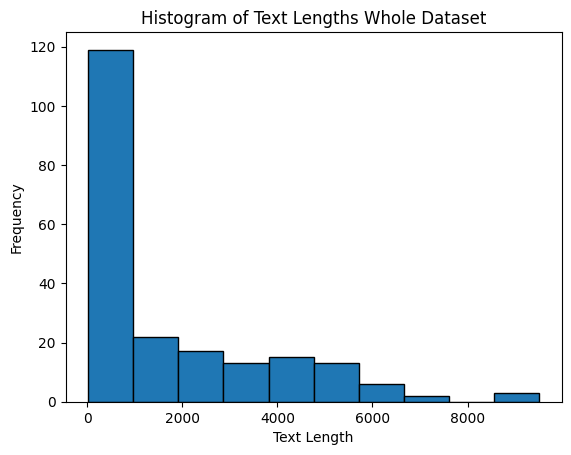

In [32]:
# plot a histogram for 'text_length' values
plt.hist(asd_subs_annotated_df['text_length'], bins=10, edgecolor='k')

# labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths Whole Dataset')

plt.show()

In [15]:
# show text length for each of the 2 categories
# filter rows where 'Category' = 'other'
other_df = asd_subs_annotated_df[asd_subs_annotated_df['Category'] == 'other']
# filter rows where 'Category' = 'asd'
asd_df = asd_subs_annotated_df[asd_subs_annotated_df['Category'] == 'asd']

# text lenght statistics for 'Category' = 'other'
print('text lenght statistics for Category=other')
print(other_df['text_length'].describe())
# text lenght statistics for 'Category' = 'asd'
print()
print('text lenght statistics for Category=asd')
print(asd_df['text_length'].describe())


text lenght statistics for Category=other
count      97.000000
mean     3035.422680
std      2244.188401
min        22.000000
25%       928.000000
50%      2657.000000
75%      4755.000000
max      9506.000000
Name: text_length, dtype: float64

text lenght statistics for Category=asd
count     113.000000
mean      614.522124
std       922.776421
min        26.000000
25%       117.000000
50%       312.000000
75%       610.000000
max      4631.000000
Name: text_length, dtype: float64


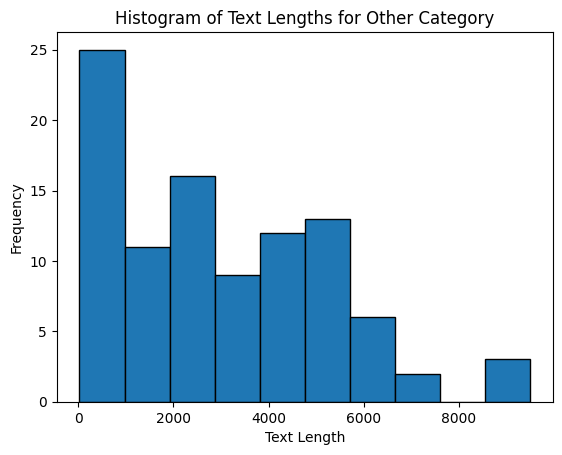

In [34]:
# plot a histogram for 'text_length' values of other category
plt.hist(other_df['text_length'], bins=10, edgecolor='k')

# labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths for Other Category')

plt.show()

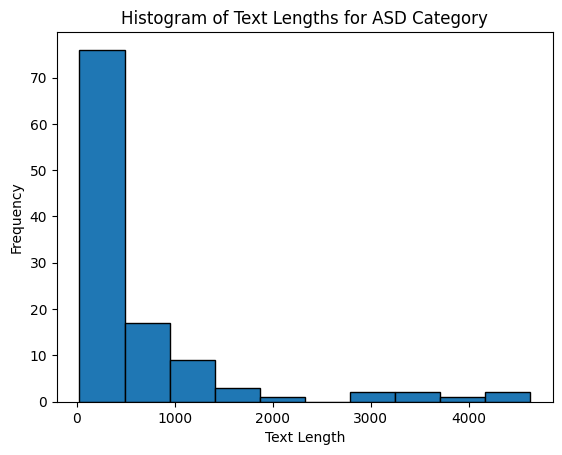

In [35]:
# plot a histogram for 'text_length' values of asd category
plt.hist(asd_df['text_length'], bins=10, edgecolor='k')

# labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths for ASD Category')

plt.show()

The average text length for the whole data set is 1892 characters. Text descriptions vary between a minumum of 22 characters to a maximum of 9506 characters. 

The mean (1732) is almost triple the median value (643). This indicates that the distribution is positively skewed - the tail on the right side (higher values) is longer compared to the left side (lower values), as seen in the histogram above. This indicates that there are some very high values (outliers) pulling the mean upward. 

https://www.analyticsvidhya.com/blog/2020/07/what-is-skewness-statistics/:
Since our data is positively skewed here, it means that it has a higher number of data points having low values (shorter text descriptions). So when we train our model on this data, it will perform better at predicting the category of subreddtis with shorter descriptions as compared to those with longer descriptions. (?)

This statistics represent text_lenght in terms of characters (inlcuding white-space). Skewed data is typical in NLP tasks. The text will need to be transformed (tokenisation) and projected into a feature space. 
All lenght text will be included in the analysis, in order to develop the largest vocabulary possible. 
As most text descriptions are under 1000 characters, i will expect models to perform best on short text.
Also, the 'other' category text data seems to be more balancend, while the 'asd' category seems to containt mostly short text (under 500 chars). Thus i would expect the models to perform better at classifing the other category ( True  negavies). (?)

In [16]:
# Category is a categorical variable
# needs to be turned into a numerical type for the analysis
# create a new column 'Asd' for the numerical values of Category: 0 = Other, 1 = Asd
asd_subs_annotated_df['asd']= asd_subs_annotated_df['Category'].apply(lambda x: 1 if x=='asd' else 0)
asd_subs_annotated_df.head(3)

,text,Category,text_length,asd
205,autismmemes autism memes Meme for people with ...,asd,71,1
488,ASDcareers The Careers of People with ASD Livi...,asd,1105,1
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,other,2073,0


In [45]:
asd_subs_annotated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 205 to 282
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         210 non-null    object
 1   Category     210 non-null    object
 2   text_length  210 non-null    int64 
 3   asd          210 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 8.2+ KB


In [17]:
# we will only use in the following analysis columns text and asd
asd_subs_annotated_df_short = asd_subs_annotated_df[['asd', 'text']]
asd_subs_annotated_df_short.head(3)

,asd,text
205,1,autismmemes autism memes Meme for people with ...
488,1,ASDcareers The Careers of People with ASD Livi...
231,0,Gamingcirclejerk Gaming Circlejerk Don Cheadle...


In [18]:
# split the data into train set ( 0.8 of the dataset ) and test set of (0.2 of the dataset)
from sklearn.model_selection import train_test_split
X = asd_subs_annotated_df_short[['text']]
y = asd_subs_annotated_df_short[['asd']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)


In [19]:
print('Training Dataset')
X_train.info()
print()
y_train.info()
print()
print('Asd-Other distribution')
print(y_train.value_counts())

Training Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 116 to 441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    168 non-null    object
dtypes: object(1)
memory usage: 2.6+ KB

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 116 to 441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   asd     168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB

Asd-Other distribution
asd
1      90
0      78
Name: count, dtype: int64


Training data contains 168 non-null values, and is relatively ballanced (90 subreddits are in the asd category and 78 are in the other category).

In [20]:
print('Test Dataset')
X_test.info()
print()
y_test.info()
print()
print('Asd-Other distribution')
print(y_test.value_counts())


Test Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 231 to 426
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42 non-null     object
dtypes: object(1)
memory usage: 672.0+ bytes

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 231 to 426
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   asd     42 non-null     int64
dtypes: int64(1)
memory usage: 672.0 bytes

Asd-Other distribution
asd
1      23
0      19
Name: count, dtype: int64


Training data contains 42 non-null values, and is relatively ballanced (23 subreddits are in the asd category and 19 are in the other category).

Both training and testing datasets are cleaned and ready for analysis.
Cross validation will be used , instead of a stand alone validation set, due to the small training set size.

I will apply different models used for supervised text classification. The best perfomant model will be used further to select the relevant asd(=autism) subreddits from the entire original dataset. 

List of models used:
- text classification with Naive Bayes 
- text classification with KNeighborsClassifier
- text classification with Random Forest
- text classification with SVM (lienar = assumes the shape of the decision boundary is linear;  and RBF = for when you don't have prior knowledge about the shape of the decision boundary)

# A. Shallow learning 

Shallow learning models were, up until recently, the go-to approach for text classification. In terms of actual classification algorithms, these methods mostly rely on general purpose classifiers that are not specific to this context (NLP). The particular challenges presented by textual data ( examples: languare is ambiguous - ex same words have different meanings, long term dependencies, meaning depends on context; high variablity in grammar, spelligns etc; high dimensionality; data is very noisy - has misspellings and inconsistencies; data is unstructured etc.) are somewhat “offloaded” to the preceding steps of the TC pipeline (Preprocessing and Projection into features space = tokenization and vectorization), which consist in the extraction of machine-interpretable features and representations from documents (i.e., text interpretation).
([Gasparetto et al., 2022, p. 10](zotero://select/library/items/7QI33EDP)) ([pdf](zotero://open-pdf/library/items/GJM85X9Y?page=10&annotation=9B4KWS9B))


## 3. Pre-processing:
Text data is unstructured data. Preprocessing this data is a first step to give this data some form of structure. 

    3.1 split text into tokens/words (=sentence segmentation/ tokanisation NLTK or Spcy or AutoTokenizer if using transformers)

    3.3 stemming (=remove prefixes and sufixes) and lemmatization (=get the base word - ext ate becomes (to)eat) - in this project lemmatization will be used as it can more accurately find the base word ( it has more complex rules than stemming -  see https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/#:~:text=Stemming%20is%20a%20process%20that,form%2C%20which%20is%20called%20Lemma.) 

#### Tokenize with spaCy

In [51]:
%%capture
%pip install -U pip setuptools wheel
%pip install -U spacy

  Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)
  Using cached setuptools-68.2.2-py3-none-any.whl (807 kB)
  Using cached wheel-0.41.2-py3-none-any.whl (64 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.0
    Uninstalling wheel-0.41.0:
      Successfully uninstalled wheel-0.41.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.2.0
    Uninstalling setuptools-63.2.0:
      Successfully uninstalled setuptools-63.2.0
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.8.0 which is incompatible.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 

In [52]:
%pip show spacy

Name: spacy
Version: 3.7.1
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages
Requires: catalogue, cymem, jinja2, langcodes, murmurhash, numpy, packaging, pathy, preshed, pydantic, requests, setuptools, smart-open, spacy-legacy, spacy-loggers, srsly, thinc, tqdm, typer, wasabi, weasel
Required-by: en-core-web-lg, en-core-web-md, en-core-web-sm
Note: you may need to restart the kernel to use updated packages.


In [21]:
import spacy

In [54]:
%%capture
!python3 -m spacy download en_core_web_lg

In [24]:
nlp = spacy.load('en_core_web_lg')

In [46]:
X_train.head(3)

,text
116,womenonthespectrum womenonthespectrum A commun...
293,The Owl House The Owl House A subreddit for th...
452,Autism Speaks Sucks Autism Speaks Sucks A comm...


In [25]:
# remove any stop words ( that were potentially missed by regex above) - > not relevant to the classification task
# remove punctuation - not relevant to classification (?maybe)
# lemmatize tokens
def preprocess(text):
    doc= nlp(text)
    new_text = []
    for t in doc:
        if t.is_stop or t.is_punct:
            continue
        new_text.append(t.lemma_)
    return ' '.join(new_text)

In [26]:
# pre-process traning set 
X_train.loc[:, 'new_text'] = X_train['text'].apply(preprocess)
X_train.head(3)

,text,new_text
116,womenonthespectrum womenonthespectrum A commun...,womenonthespectrum womenonthespectrum communit...
293,The Owl House The Owl House A subreddit for th...,Owl House Owl House subreddit Disney fantasy c...
452,Autism Speaks Sucks Autism Speaks Sucks A comm...,autism speak Sucks autism speak suck community...


In [27]:
# difference in text before and after preprocessing
doc_text = nlp(X_train.text[116])
doc_new_text = nlp(X_train.new_text[116])
print([t.text for t in doc_text])
print([t.text for t in doc_new_text])

['womenonthespectrum', 'womenonthespectrum', 'A', 'community', 'specifically', 'for', 'women', 'nonbinary', 'and', 'afab', 'people', 'on', 'the', 'spectrum', 'to', 'vent', 'discuss', 'topics', 'related', 'to', 'autism', 'and', 'support', 'each', 'other']
['womenonthespectrum', 'womenonthespectrum', 'community', 'specifically', 'woman', 'nonbinary', 'afab', 'people', 'spectrum', 'vent', 'discuss', 'topic', 'relate', 'autism', 'support']


In [28]:
# pre-process testinf set 
X_test.loc[:, 'new_text'] = X_test['text'].apply(preprocess)
X_test.head(3)

,text,new_text
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,Gamingcirclejerk gaming Circlejerk Don Cheadle...
243,ASDpeersupport ASD Peer Support Peer based sup...,ASDpeersupport ASD Peer support Peer base supp...
392,selfharm A Subreddit for Self Harmers A subred...,selfharm Subreddit Self Harmers subreddit self...


## 4. 5. 6. Vectorize, Apply Classifier and Evaluate the model - uses sklearn.pipeline


4. feature engineering (= convert text / document into vector)
    count-vector
    tf-idf
    one-hot encode - not really used due to size and sparcity problems
    word/token-emebeding
5. apply classifier ( any machine learning model classifier ) - use gridSearchCV to see which is the best performing classifier ?
6. evaluate  model: Accuracy, Precision, Recall, F1 score ( if not good , go back to preprocessing step )

##### Approach 1. Vectorization does not involve any machine learning and is only based on applying frequency counts to tokens/words (Count Vectorization and TF-IDF)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold, cross_val_predict

from sklearn.metrics import classification_report, confusion_matrix

def classify(vectorizer, model, x_train, y_train, x_test, y_test, k_folds=5, scaler=None):
    # create the pipeline
    clf = Pipeline([
        ('vectorizer', vectorizer),
        ('scaler', scaler),
        ('model', model)
    ])
    # initialize StratifiedKFold for cross-validation
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # perform k-fold (k=5) cross-validation 
    y_pred_cv = cross_val_predict(clf, x_train, y_train, cv=kf)
    
    # fit the model on the training data
    clf.fit(x_train, y_train)
    # make prediction using test data
    y_pred = clf.predict(x_test)

    # classification report and confusion matrix for cross-validated predictions
    print("Cross-validated Classification Report:\n", classification_report(y_train, y_pred_cv))
    print("Cross-validated Confusion Matrix:\n", confusion_matrix(y_train, y_pred_cv))
    
    # classification report and confusion matrix for test data 
    print("\nTest Data Classification Report:\n", classification_report(y_test, y_pred))
    print("Test Data Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [30]:
y_train.asd.shape, X_train.new_text.shape


((168,), (168,))

In [63]:
np.random.seed(7)
vectorizers = [CountVectorizer(), TfidfVectorizer()]
models = [KNeighborsClassifier(), MultinomialNB(), RandomForestClassifier(), LogisticRegression(), SVC(kernel='linear'), SVC(kernel='rbf')]

for v in vectorizers:
    print(v)
    for m in models:
        print(v, m)
        classify(v, m, X_train.new_text, y_train.asd, X_test.new_text, y_test.asd)
    print()
        

CountVectorizer()
CountVectorizer() KNeighborsClassifier()
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.51      0.67        78
           1       0.70      0.98      0.81        90

    accuracy                           0.76       168
   macro avg       0.83      0.75      0.74       168
weighted avg       0.82      0.76      0.75       168

Cross-validated Confusion Matrix:
 [[40 38]
 [ 2 88]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.53      0.69        19
           1       0.72      1.00      0.84        23

    accuracy                           0.79        42
   macro avg       0.86      0.76      0.76        42
weighted avg       0.85      0.79      0.77        42

Test Data Confusion Matrix:
 [[10  9]
 [ 0 23]]
CountVectorizer() MultinomialNB()
Cross-validated Classification Report:
               precision    recall  f

All the models classify non-ASD subreddits (0) with higher precission - as expected (see above discussion ).

Using a simple frequency word count vectorisation method (CountVectorizer) resulted in an accuracy on test data of:

CountVectorizer: 

0.79 - for KNN (trainig data 0.76 => not overfit)<br>
0.88 - for multinomial naive bayes (training data 0.92 => maybe overfit?)<br>
0.81 - for the Random Forest (training data 0.86 => maybe overift)<br>
0.83 - for the LogisticRegression (training data 0.89 => maybe overfit)<br>
0.83 - for SVM linear kernel (training data 0.86=> maybe overfit?)<br>
0.81 - for SVM rbf kernel (training data 0.82 => not overfit)<br>

TF-IDF:

0.88 - for the KNN (training data 0.90 => not overfit)<br>
0.88 - for multinomial naive bayes (training data 0.92 => maybe overfit?)<br>
0.81 - for the Random Forest (training data 0.86 => maybe overift)<br>
0.90 - for the LogisticRegression (training data 0.92 => not overfit)<br>
0.93 - for SVM linear kernel (training data 0.95 => not overfit)<br>
0.90 - for SVM rbf kernel (training data 0.92 => not overfit)<br>

The predictions were improved, as expected, when using TF-IDF to vectorize the tokens ( this way frequent words, common to all the documents are given lower importance, and less common words are given more weight). The best performing model - similar performance on test set, no False negatives - were the Logistic regression and SVM models.

##### Approach 2. Vectorization using shallow neural nets (spaCy's GloVe)
Token vectors are the result of utilising a shallow neural networks in order to create a high dimensional vector for each word (though they are much smaller and denser than, for example, TF-IDF vectors). - GloVe ( why not word2vec? - easier to train as it creates lower dimentions vectors; more suitable for large datasets or limited computer power; neither is able to handle OOV - out of vocab -  words). GloVe's unit on which the neural nets is trained is *word*.  

maybe try also FastText?
“FastText is able to handle OOV words, as long as it has seen its composing n-grams during training. Both GloVe and Word2Vec are instead unable to handle the case of OOV words.” ([Gasparetto et al., 2022, p. 10](zotero://select/library/items/7QI33EDP)) ([pdf](zotero://open-pdf/library/items/GJM85X9Y?page=10&annotation=6H5SYFFG))

In [64]:
# spaCy large English model provides vectors (GloVe)
# all vectors are of lenght 300 (= 300 dimensions )
for text in X_train.text:
    doc = nlp(text)
    print(doc.vector.shape)
    break

(300,)


spaCy 's English language model - large , provides 514k keys, 514k unique vectors (each=300 dimensions) (https://spacy.io/models/en)

This model provides GloVe vectors trained on Common Crawl (https://github.com/explosion/spacy-models/releases//tag/en_core_web_lg-2.3.1) 

Common Crawl database: https://en.wikipedia.org/wiki/Common_Crawl

In [65]:
for text in X_train.text:
    doc = nlp(text)
    print(doc.vector)
    break

[-1.8486128e+00  1.5892310e+00 -3.2409065e+00 -4.3019190e-02
  4.0609274e+00  4.7510800e-01  4.8715359e-01  4.1747169e+00
 -1.4294057e+00  4.5436048e-03  5.3522205e+00  2.2574072e+00
 -4.5851417e+00  1.3712009e+00  4.4433114e-01  2.2298615e+00
  2.1136811e+00 -1.3794917e+00 -3.0008421e+00 -2.5509632e+00
  8.7831706e-02 -1.9485286e+00 -1.1433463e+00 -2.1321458e-01
  1.0417217e+00 -1.7193288e+00 -2.3502305e+00  9.7079217e-01
 -2.0635519e+00  6.4479995e-01  8.1923783e-01 -4.6718398e-01
 -1.9332402e+00 -3.0946743e+00 -1.9094207e+00 -5.7582241e-01
  6.8277502e-01  3.5950679e-01  9.2482871e-01  2.8120521e-01
  1.7119380e+00 -9.0557039e-02  1.2482457e-01 -8.7007560e-02
 -1.6891894e+00  1.6687484e+00  9.7832167e-01 -1.8785739e+00
 -1.3737924e+00  2.2778971e+00 -4.9244021e-03  2.4940062e+00
 -1.3629605e+00 -4.8081613e+00 -1.8509319e+00  1.8132876e+00
 -1.2980604e+00  1.1212356e+00  1.4739300e+00 -1.1941451e+00
  9.5256023e-02  4.5365158e-01 -1.1192365e+00 -3.8787171e-02
  2.7721593e+00  1.74512

In [66]:
# define a vectorizer function that uses spaCy GloVe vectors
def text_to_vectors(texts):
    return [nlp(text).vector for text in texts]

In [67]:

# GloVe vectors contain negative values and this is not suitable to MultinomialNB()  ( it needs positive values to work )
# we can rescale with MinMaxScaler = This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
# for different types and applications of Naive Bayse : https://www.ibm.com/topics/naive-bayes#:~:text=The%20Na%C3%AFve%20Bayes%20classifier%20is,a%20given%20class%20or%20category.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

np.random.seed(7)

# save the vectorizer function above into a format suitable for use in the clf pipeline ( in the classify function )
vect = FunctionTransformer(text_to_vectors)

# fit the models and 
for m in models:
    print('GloVe', m)

    if isinstance(m, MultinomialNB):
        scaler = MinMaxScaler()
    else:
        scaler = None

    classify(vect, m, X_train.new_text, y_train.asd, X_test.new_text, y_test.asd, scaler=scaler)
    print()

GloVe KNeighborsClassifier()


Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83        78
           1       0.92      0.73      0.81        90

    accuracy                           0.82       168
   macro avg       0.83      0.83      0.82       168
weighted avg       0.84      0.82      0.82       168

Cross-validated Confusion Matrix:
 [[72  6]
 [24 66]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.84      0.70      0.76        23

    accuracy                           0.76        42
   macro avg       0.77      0.77      0.76        42
weighted avg       0.78      0.76      0.76        42

Test Data Confusion Matrix:
 [[16  3]
 [ 7 16]]

GloVe MultinomialNB()
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86        

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87        78
           1       0.89      0.88      0.88        90

    accuracy                           0.88       168
   macro avg       0.87      0.87      0.87       168
weighted avg       0.88      0.88      0.88       168

Cross-validated Confusion Matrix:
 [[68 10]
 [11 79]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80        19
           1       0.81      0.91      0.86        23

    accuracy                           0.83        42
   macro avg       0.84      0.82      0.83        42
weighted avg       0.84      0.83      0.83        42

Test Data Confusion Matrix:
 [[14  5]
 [ 2 21]]

GloVe SVC(kernel='linear')
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83   

With GloVe embedings, some models classified ASD subreddits (1) with higher or equal precission, compared to the Other category (0) - contrary to what was expected ( see above discussion ) - why? maybe ASD class has shorter text, but more consistent patterns.

Using a word embeding method method (GloVe) resulted in an accuracy ranging from:

0.76 - for KNN ( training data was 0.82 => overfit)<br>
0.81 - multinomial naive bayes (training data 0.86 => maybe overfit)<br>
0.88 - for Random Forest ( training data 0.88 => not overfit)<br>
0.83 - for the LogisticRegression (training data 0.88 => maybe overfit)<br>
0.81 - SVM linear kernel (training data 0.85 => not overfit)<br>
0.81 - SVM RBF kernel ( training data 0.87 => maybe overfit?)<br>


The performance of the model using GloVe embedings is lower that vectorization using count frequencies (see above - accuracy range (0.76 to 0.93 )). This might be due to the information loss resulted after GloVe ( - it does dimensionality reduction ). Another reason could be the difference in type of text between the current data base and Common Crawl ( on which the GloVe embedings were trained ) - CountVectorizer and TF-IDF create own specific word vectors for the current dataset, while spaCy's GloVe model uses pretrained ones (we used out of the box, pretrained vectors ). 

“GloVe models utilise a dimensionality reduction step in order to handle the large dimensions of the word co-occurrence matrix that it uses in its calculations. Although compressing representations can arguably lead to a more robust representation (as it theoretically forces the model to try to preserve the most significant pieces of information), a bigger advantage comes from the fact that this approach is more suitable for parallelisation, making it easier to train on more data.” ([Gasparetto et al., 2022, p. 9](zotero://select/library/items/7QI33EDP)) ([pdf](zotero://open-pdf/library/items/GJM85X9Y?page=9&annotation=7IIF5HKM))


##### Approach 3. Vectorization using shallow neural nets (word2vec in Gensim)

SpaCy's out of the box GloVe model does not perform very well on domain specific data. 
Apply word2vec -> use gensim as it makes it easier to train own model and has more out of the box models to choose from.

https://radimrehurek.com/gensim/models/word2vec.html

##### Approach 3a. word2vec out of the box

In [68]:
%%capture
%pip install gensim

In [31]:
import gensim
import gensim.downloader as api
from pprint import pprint

# list pretrained models available in gensim
# the training copus used for available models for english is google-news
# this type of text is different then text on reddit 
# the expectation is that the out of the box model will not have improved performance compared to count vectorizers used initially
pprint(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']


In [32]:
# load the word2vec-google-news-300 pretrained model - the vector size is 300
embeding_model = api.load('word2vec-google-news-300')

In [55]:
embeding_model.most_similar('autism')

[('autism_spectrum_disorders', 0.8032153248786926),
 ('autistic', 0.7907200455665588),
 ('Autism', 0.7736356854438782),
 ('autism_spectrum_disorder', 0.7603526711463928),
 ('autism_spectrum', 0.7037034630775452),
 ('ASDs', 0.6698784828186035),
 ('developmental_disorders', 0.6663668155670166),
 ('ADHD', 0.6658616065979004),
 ('Autism_Spectrum_Disorder_ASD', 0.6601077914237976),
 ('developmental_disorder', 0.6575655937194824)]

In [33]:
# tokenize training text
X_train['tokenized_text'] = X_train.new_text.apply(gensim.utils.tokenize)
X_train['tokenized_text'] = X_train.tokenized_text.apply(list)

X_train.head(2)

,text,new_text,tokenized_text
116,womenonthespectrum womenonthespectrum A commun...,womenonthespectrum womenonthespectrum communit...,"[womenonthespectrum, womenonthespectrum, commu..."
293,The Owl House The Owl House A subreddit for th...,Owl House Owl House subreddit Disney fantasy c...,"[Owl, House, Owl, House, subreddit, Disney, fa..."


In [34]:
# tokenize testing text
X_test['tokenized_text'] = X_test.new_text.apply(gensim.utils.tokenize)
X_test['tokenized_text'] = X_test.tokenized_text.apply(list)
X_test.head(2)

,text,new_text,tokenized_text
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,Gamingcirclejerk gaming Circlejerk Don Cheadle...,"[Gamingcirclejerk, gaming, Circlejerk, Don, Ch..."
243,ASDpeersupport ASD Peer Support Peer based sup...,ASDpeersupport ASD Peer support Peer base supp...,"[ASDpeersupport, ASD, Peer, support, Peer, bas..."


In [74]:
# function to get the text vectors 
def pretrained_vectorizer(X, vector_size=300):
    doc_vectors = []
    for index, row in X.iterrows():
        tokenized_text = row['tokenized_text'] 
        doc_vector = np.zeros(vector_size)
        for word in tokenized_text:
            if word in embeding_model:
                doc_vector += embeding_model[word]

        doc_vectors.append(doc_vector)

    return np.array(doc_vectors)

In [75]:
X_train_vectorized = pretrained_vectorizer(X_train)
# all the text vectors are the same size 
for i, v in enumerate(X_train_vectorized):
    print(len(X_train.tokenized_text.iloc[i]), len(v))

15 300
685 300
14 300
230 300
12 300
7 300
40 300
352 300
177 300
8 300
844 300
490 300
4 300
350 300
315 300
527 300
69 300
99 300
166 300
33 300
36 300
547 300
12 300
4 300
152 300
50 300
72 300
377 300
4 300
544 300
492 300
60 300
465 300
40 300
4 300
232 300
4 300
12 300
10 300
11 300
853 300
13 300
453 300
81 300
122 300
786 300
153 300
226 300
376 300
27 300
35 300
549 300
79 300
36 300
60 300
137 300
10 300
539 300
28 300
48 300
23 300
26 300
47 300
51 300
141 300
4 300
114 300
130 300
166 300
40 300
480 300
466 300
28 300
11 300
660 300
663 300
338 300
16 300
31 300
320 300
12 300
99 300
234 300
20 300
87 300
37 300
113 300
12 300
42 300
11 300
162 300
44 300
631 300
50 300
270 300
12 300
73 300
45 300
12 300
9 300
14 300
179 300
269 300
9 300
521 300
15 300
674 300
60 300
595 300
468 300
386 300
75 300
4 300
169 300
38 300
50 300
35 300
12 300
18 300
9 300
418 300
13 300
21 300
18 300
330 300
18 300
459 300
846 300
656 300
64 300
295 300
56 300
13 300
35 300
9 300
55 300
8 300

In [76]:
np.random.seed(7)

# save the vectorizer function above into a format suitable for use in the clf pipeline ( in the classify function )
vect_pretrained = FunctionTransformer(pretrained_vectorizer, validate=False)

# fit the classification models 
for m in models:
    print('word2Vec-pretrained', m)

    if isinstance(m, MultinomialNB):
        scaler = MinMaxScaler()
    else:
        scaler = None

    classify(vect_pretrained, m, X_train, y_train.asd, X_test, y_test.asd, scaler=scaler)
    print()

word2Vec-pretrained KNeighborsClassifier()
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.82        78
           1       0.81      0.93      0.87        90

    accuracy                           0.85       168
   macro avg       0.86      0.84      0.84       168
weighted avg       0.85      0.85      0.84       168

Cross-validated Confusion Matrix:
 [[58 20]
 [ 6 84]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.63      0.75        19
           1       0.76      0.96      0.85        23

    accuracy                           0.81        42
   macro avg       0.84      0.79      0.80        42
weighted avg       0.83      0.81      0.80        42

Test Data Confusion Matrix:
 [[12  7]
 [ 1 22]]

word2Vec-pretrained MultinomialNB()
Cross-validated Classification Report:
               precision    recall  f1-score   sup

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90        78
           1       0.89      0.94      0.92        90

    accuracy                           0.91       168
   macro avg       0.91      0.91      0.91       168
weighted avg       0.91      0.91      0.91       168

Cross-validated Confusion Matrix:
 [[68 10]
 [ 5 85]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74        19
           1       0.77      0.87      0.82        23

    accuracy                           0.79        42
   macro avg       0.79      0.78      0.78        42
weighted avg       0.79      0.79      0.78        42

Test Data Confusion Matrix:
 [[13  6]
 [ 3 20]]

word2Vec-pretrained SVC(kernel='linear')
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.8

With word2vec embedings, most models classified the Other category (0) with higher  precission - as was expected ( see above discussion ).

Using a word embeding method method (word2Vec - google news corpus - from Gensim) resulted in an accuracy ranging from:

0.81 - for KNN ( training data was 0.85 => not overfit)<br>
0.76 - multinomial naive bayes (training data 0.80 => overfit)<br>
0.74 - for Random Forest ( training data 0.87 => overfit)<br>
0.79 - for Logistic regression ( training data 0.91 => overfit)<br>
0.81 - SVM linear kernel (training data 0.89 => maybe overfit)<br>
0.79 - SVM RBF kernel ( training data 0.81 => not overfit)<br>


Same as GloVe, the performance of the models using word2vec embedings is lower than vectorization using count frequencies (see above - accuracy range (0.76 to 0.93 )). The same reasoning applies: the difference in type of text between the current data base and google news text ( on which the word2vec embedings were trained ) - CountVectorizer and TF-IDF create own specific word vectors for the current dataset, while word2vec model uses pretrained ones (we used out of the box, pretrained vectors ). 


##### Approach 3b. word2vec trained on the present corpus 
The dataset is small, and this approach is expected to result in poor performance

In [77]:
from gensim.models import Word2Vec

In [78]:
# https://rare-technologies.com/word2vec-tutorial/
# initialise a word2vec model
w2v_model = gensim.models.Word2Vec(
    vector_size=300,
    window=10,
    min_count=5,     # some text descriptions are very short and we want to include all the information/data in the training
    epochs=10       # default is 5
) 

In [79]:
# build a vocab
np.random.seed(7)
w2v_model.build_vocab(X_train.tokenized_text)

In [80]:
w2v_model.corpus_count

168

In [81]:
# train the model
np.random.seed(7)
w2v_model.train(
    X_train.tokenized_text, 
    total_examples=w2v_model.corpus_count,
    epochs=w2v_model.epochs,
)

(176328, 310770)

In [82]:
w2v_model.save('models/w2v_subreddits.model')

In [83]:
w2v_model.wv.most_similar('autism')

[('spectrum', 0.9988039135932922),
 ('Asperger', 0.997205376625061),
 ('Autism', 0.9946227073669434),
 ('discuss', 0.9921412467956543),
 ('clinically', 0.991982102394104),
 ('diagnostic', 0.9908242225646973),
 ('community', 0.9899144172668457),
 ('people', 0.9887209534645081),
 ('autistic', 0.987491250038147),
 ('help', 0.9866023659706116)]

In [84]:
# get word vectors
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train.tokenized_text], dtype=object)
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test.tokenized_text], dtype=object)


In [85]:
# the vectors obtained above are not of equal size for the whole corpus
# we need to average the word vectors into a text vector of size 300 - each text will be represented as a vector of size 300 
# size = 300 because this it the size we used so far for the other models and for consistenci reasons we kept the same for the current model
for i, v in enumerate(X_train_vect):
    print(len(X_train.tokenized_text.iloc[i]), len(v))

15 12
685 198
14 13
230 140
12 11
7 6
40 30
352 254
177 121
8 7
844 622
490 308
4 4
350 280
315 205
527 437
69 59
99 62
166 132
33 19
36 23
547 380
12 9
4 2
152 102
50 43
72 46
377 286
4 3
544 478
492 344
60 35
465 359
40 30
4 2
232 151
4 2
12 6
10 7
11 10
853 635
13 7
453 309
81 63
122 75
786 607
153 112
226 184
376 281
27 21
35 31
549 409
79 42
36 21
60 54
137 95
10 10
539 371
28 18
48 37
23 17
26 20
47 41
51 48
141 124
4 4
114 62
130 102
166 132
40 28
480 414
466 340
28 20
11 9
660 510
663 478
338 235
16 12
31 21
320 247
12 4
99 89
234 152
20 10
87 57
37 30
113 76
12 10
42 26
11 7
162 116
44 28
631 516
50 39
270 207
12 10
73 41
45 39
12 11
9 6
14 14
179 132
269 205
9 3
521 386
15 15
674 519
60 52
595 456
468 222
386 281
75 21
4 0
169 135
38 26
50 28
35 27
12 8
18 7
9 4
418 298
13 11
21 12
18 13
330 228
18 16
459 363
846 753
656 455
64 52
295 229
56 46
13 12
35 14
9 8
55 50
8 4
421 313
35 24
64 53
305 232
451 314
464 274
543 403
10 6
10 10
77 61
22 18
215 180
9 5
12 10
78 68
604 407


In [ ]:
X_train_vect.shape, X_test_vect.shape

In [87]:
# function to compute text vectors by averaging the word vectors for the words contained in the text
# average word vector to get a singel text vector of size=300 ( see above discussion )
def w2v_vectorizer(X, vector_size=300):
    words = set(w2v_model.wv.index_to_key)
    X_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                      for ls in X], dtype=object)

    X_vect_avg = []
    for v in X_vect:
        if v.size:
            X_vect_avg.append(v.mean(axis=0))
        else:
            X_vect_avg.append(np.zeros(vector_size, dtype=float))

    return np.array(X_vect_avg)


In [88]:
X_train_vectorized = w2v_vectorizer(X_train.tokenized_text)
# now all the text vectors are the same size
for i, v in enumerate(X_train_vectorized):
    print(len(X_train.tokenized_text.iloc[i]), len(v))

15 300
685 300
14 300
230 300
12 300
7 300
40 300
352 300
177 300
8 300
844 300
490 300
4 300
350 300
315 300
527 300
69 300
99 300
166 300
33 300
36 300
547 300
12 300
4 300
152 300
50 300
72 300
377 300
4 300
544 300
492 300
60 300
465 300
40 300
4 300
232 300
4 300
12 300
10 300
11 300
853 300
13 300
453 300
81 300
122 300
786 300
153 300
226 300
376 300
27 300
35 300
549 300
79 300
36 300
60 300
137 300
10 300
539 300
28 300
48 300
23 300
26 300
47 300
51 300
141 300
4 300
114 300
130 300
166 300
40 300
480 300
466 300
28 300
11 300
660 300
663 300
338 300
16 300
31 300
320 300
12 300
99 300
234 300
20 300
87 300
37 300
113 300
12 300
42 300
11 300
162 300
44 300
631 300
50 300
270 300
12 300
73 300
45 300
12 300
9 300
14 300
179 300
269 300
9 300
521 300
15 300
674 300
60 300
595 300
468 300
386 300
75 300
4 300
169 300
38 300
50 300
35 300
12 300
18 300
9 300
418 300
13 300
21 300
18 300
330 300
18 300
459 300
846 300
656 300
64 300
295 300
56 300
13 300
35 300
9 300
55 300
8 300

In [89]:
# fit a model for predictions - this also evaluates the performance of current word2vec model
# (word2vec is an unsupervised model; thus it can only be evaluated when solving a specific task - here text classification)
# classification models used ( to be consistent with the previous analysis )
models

[KNeighborsClassifier(),
 MultinomialNB(),
 RandomForestClassifier(),
 LogisticRegression(),
 SVC(kernel='linear'),
 SVC()]

In [90]:
import warnings

# dont show VisibleDeprecationWarning
warnings.filterwarnings("ignore")

np.random.seed(7)

# save the vectorizer function above into a format suitable for use in the clf pipeline ( in the classify function )
vect = FunctionTransformer(w2v_vectorizer, validate=False)

# fit the classification models 
for m in models:
    print('Custom trained word2Vec', m)

    if isinstance(m, MultinomialNB):
        scaler = MinMaxScaler()
    else:
        scaler = None

    classify(vect, m, X_train.tokenized_text, y_train.asd, X_test.tokenized_text, y_test.asd, scaler=scaler)
    print()


Custom trained word2Vec KNeighborsClassifier()
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87        78
           1       0.90      0.87      0.88        90

    accuracy                           0.88       168
   macro avg       0.87      0.88      0.87       168
weighted avg       0.88      0.88      0.88       168

Cross-validated Confusion Matrix:
 [[69  9]
 [12 78]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.88      0.91      0.89        23

    accuracy                           0.88        42
   macro avg       0.88      0.88      0.88        42
weighted avg       0.88      0.88      0.88        42

Test Data Confusion Matrix:
 [[16  3]
 [ 2 21]]

Custom trained word2Vec MultinomialNB()


Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82        78
           1       0.81      0.92      0.86        90

    accuracy                           0.85       168
   macro avg       0.85      0.84      0.84       168
weighted avg       0.85      0.85      0.84       168

Cross-validated Confusion Matrix:
 [[59 19]
 [ 7 83]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       0.79      1.00      0.88        23

    accuracy                           0.86        42
   macro avg       0.90      0.84      0.85        42
weighted avg       0.89      0.86      0.85        42

Test Data Confusion Matrix:
 [[13  6]
 [ 0 23]]

Custom trained word2Vec RandomForestClassifier()
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.84 

The word2vec embedings trained on the current dataset, performed better than the out of the box, pretrained model available in Gensim. Accuracy for the models:

0.88 - for KNN ( training data was 0.88 => not overfit)<br>
0.86 - multinomial naive bayes (training data 0.85 => not overfit)<br>
0.86 - for Random Forest ( training data 0.87 => not overfit)<br>
0.86 - for Logistic Regression ( training data 0.88 => not overfit)<br>
0.88 - SVM linear kernel (training data 0.89 => not overfit)<br>
0.86 - SVM RBF kernel ( training data 0.86 => not overfit)<br>

Training a word2vec model on this current dataset did not improve performance when compared to previous frequency based vectorizers. This is a complex model, and for it to perform best it needs a much larger dataset than the one we currently have. This analysis indicates that perhaps for simple text classification tasks, with a small dataset, classical vectorization tehniques based on word counts might be more appropriate. 

However it is worth noting that the overall, performance on test sets was better than trainig, sugessting that the models trained with these vectors are less likely to be overfitted. Also we notice consistent, similar performance with all 4 classification models used - this is in line with the reasoning that in NLP the quality of text representations is more important that the actual machine learning algorithm used for classification or prediction (need citation). 


##### Approach 4. Vectorization using shallow neural nets (GloVe - pretrained on twitter data )

To my knowledge there is no  pretrained model on Reddit data. But there are emebding models trained on social media data : for ex. glove-twitter-200 from the Gensim library. Will this result in a better performance?

In [91]:
# load the glove-twitter-200 pretrained model - the vector size is 200
embeding_model = api.load('glove-twitter-200')

In [92]:
X_train_vectorized = pretrained_vectorizer(X_train,vector_size=200)
# all the text vectors are the same size 
for i, v in enumerate(X_train_vectorized):
    print(len(X_train.tokenized_text.iloc[i]), len(v))

15 200
685 200
14 200
230 200
12 200
7 200
40 200
352 200
177 200
8 200
844 200
490 200
4 200
350 200
315 200
527 200
69 200
99 200
166 200
33 200
36 200
547 200
12 200
4 200
152 200
50 200
72 200
377 200
4 200
544 200
492 200
60 200
465 200
40 200
4 200
232 200
4 200
12 200
10 200
11 200
853 200
13 200
453 200
81 200
122 200
786 200
153 200
226 200
376 200
27 200
35 200
549 200
79 200
36 200
60 200
137 200
10 200
539 200
28 200
48 200
23 200
26 200
47 200
51 200
141 200
4 200
114 200
130 200
166 200
40 200
480 200
466 200
28 200
11 200
660 200
663 200
338 200
16 200
31 200
320 200
12 200
99 200
234 200
20 200
87 200
37 200
113 200
12 200
42 200
11 200
162 200
44 200
631 200
50 200
270 200
12 200
73 200
45 200
12 200
9 200
14 200
179 200
269 200
9 200
521 200
15 200
674 200
60 200
595 200
468 200
386 200
75 200
4 200
169 200
38 200
50 200
35 200
12 200
18 200
9 200
418 200
13 200
21 200
18 200
330 200
18 200
459 200
846 200
656 200
64 200
295 200
56 200
13 200
35 200
9 200
55 200
8 200

In [93]:
# vectorizer function for vector size=200
def pretrained_vectorizer200(X):
    return pretrained_vectorizer(X, 200)

In [94]:
np.random.seed(7)

# save the vectorizer function above into a format suitable for use in the clf pipeline ( in the classify function )
vect_pretrained = FunctionTransformer(pretrained_vectorizer200, validate=False)

# fit the classification models 
for m in models:
    print('GloVe Twitter', m)

    if isinstance(m, MultinomialNB):
        scaler = MinMaxScaler()
    else:
        scaler = None

    classify(vect_pretrained, m, X_train, y_train.asd, X_test, y_test.asd, scaler=scaler)
    print()

GloVe Twitter KNeighborsClassifier()
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79        78
           1       0.79      0.90      0.84        90

    accuracy                           0.82       168
   macro avg       0.83      0.82      0.82       168
weighted avg       0.83      0.82      0.82       168

Cross-validated Confusion Matrix:
 [[57 21]
 [ 9 81]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.58      0.65        19
           1       0.70      0.83      0.76        23

    accuracy                           0.71        42
   macro avg       0.72      0.70      0.70        42
weighted avg       0.72      0.71      0.71        42

Test Data Confusion Matrix:
 [[11  8]
 [ 4 19]]

GloVe Twitter MultinomialNB()
Cross-validated Classification Report:
               precision    recall  f1-score   support

      

The GloVe model trained on twitter data did not improve perfomance. 
For the present dataset the frequency count vectorizers (TFIDF + SVM or Logistic regression) and the custom trained word2vec vectorizer seem to perform the best so far. 

##### Approach 5. Vectorization using shallow neural nets (FastText)

https://fasttext.cc/<br>

https://towardsdatascience.com/fasttext-under-the-hood-11efc57b2b3<br>

why? Argued to result in better word representations and also deals with OOV problem + can be be easly trained to create vectors specific to the current dataset.

“FastText is one of the most novel techniques, developed by Bojanowski et al. [35]. The main concern addressed by this method is the fact that its predecessors ignore the morphology of words by assigning a distinct vector to each word.” ([Gasparetto et al., 2022, p. 10](zotero://select/library/items/7QI33EDP)) ([pdf](zotero://open-pdf/library/items/GJM85X9Y?page=10&annotation=IZPGLGLF))

“FastText is able to handle OOV words, as long as it has seen its composing n-grams during training. Both GloVe and Word2Vec are instead unable to handle the case of OOV words.” ([Gasparetto et al., 2022, p. 10](zotero://select/library/items/7QI33EDP)) ([pdf](zotero://open-pdf/library/items/GJM85X9Y?page=10&annotation=6H5SYFFG)) - FastText unit on which the neural net is trained is *character n-gram* 


In [95]:
%%capture
%pip install fasttext

In [36]:
X_train.head(3)

,text,new_text,tokenized_text
116,womenonthespectrum womenonthespectrum A commun...,womenonthespectrum womenonthespectrum communit...,"[womenonthespectrum, womenonthespectrum, commu..."
293,The Owl House The Owl House A subreddit for th...,Owl House Owl House subreddit Disney fantasy c...,"[Owl, House, Owl, House, subreddit, Disney, fa..."
452,Autism Speaks Sucks Autism Speaks Sucks A comm...,autism speak Sucks autism speak suck community...,"[autism, speak, Sucks, autism, speak, suck, co..."


In [37]:
# we will use the new_text (the clenaed/prerpocessed text)
X_train.new_text.head(3)

116    womenonthespectrum womenonthespectrum communit...
293    Owl House Owl House subreddit Disney fantasy c...
452    autism speak Sucks autism speak suck community...
Name: new_text, dtype: object

In [38]:
import fasttext

<b>Approach 5a. Pretrained FastText vectors + classical classification algorithms</b>

In [99]:
ft_model_path = r'models/fasttext_pretrained/crawl-300d-2M-subword/crawl-300d-2M-subword.bin'

In [100]:
# load the pretrained english model fro fasttext - trained on Crawl dataset, vector size=300
ft_en_model = fasttext.load_model(ft_model_path)

In [101]:
ft_en_model.get_nearest_neighbors('autism')

[(0.8590065836906433, 'Autism'),
 (0.8022950887680054, 'autistic'),
 (0.7881932854652405, 'autisms'),
 (0.7856281399726868, 'autism-'),
 (0.7737045288085938, 'autism-related'),
 (0.7696868777275085, 'austism'),
 (0.766737163066864, 'non-autism'),
 (0.7601718902587891, 'ASD'),
 (0.7600443959236145, 'autistics'),
 (0.7465263605117798, 'autism-spectrum')]

In [102]:
# creates a fastText vecotrizer 
from sklearn.base import BaseEstimator, TransformerMixin

class FastTextVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, fasttext_model_path):
        self.fasttext_model_path = fasttext_model_path
        self.fasttext_model = None  # initialize the FastText model as None

    def fit(self, X, y=None):
        # load the FastText model only once during fitting
        if self.fasttext_model is None:
            self.fasttext_model = fasttext.load_model(self.fasttext_model_path)
        return self


    def transform(self, X):
        # check model is loaded before transforming
        if self.fasttext_model is None:
            raise ValueError("FastText model is not loaded. Call fit() before transform().")

        vectors = [self.fasttext_model.get_sentence_vector(text) for text in X]
        return np.array(vectors)


In [103]:
# save the fasttext vectorizer function above into a format suitable for use in the clf pipeline ( in the classify function )
ft_vectorizer = FastTextVectorizer(ft_model_path)

In [104]:
np.random.seed(7)

scaler = None
# fit the classification models 
for m in models:
    print('fastText en-pretrained', m)

    if isinstance(m, MultinomialNB):
        scaler = MinMaxScaler()
    else:
        scaler = None

    classify(ft_vectorizer, m, X_train.new_text, y_train.asd, X_test.new_text, y_test.asd, scaler=scaler)
    print()

fastText en-pretrained KNeighborsClassifier()


Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89        78
           1       0.92      0.89      0.90        90

    accuracy                           0.90       168
   macro avg       0.90      0.90      0.90       168
weighted avg       0.90      0.90      0.90       168

Cross-validated Confusion Matrix:
 [[71  7]
 [10 80]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        19
           1       0.83      0.83      0.83        23

    accuracy                           0.81        42
   macro avg       0.81      0.81      0.81        42
weighted avg       0.81      0.81      0.81        42

Test Data Confusion Matrix:
 [[15  4]
 [ 4 19]]

fastText en-pretrained MultinomialNB()


Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87        78
           1       0.95      0.80      0.87        90

    accuracy                           0.87       168
   macro avg       0.88      0.87      0.87       168
weighted avg       0.88      0.87      0.87       168

Cross-validated Confusion Matrix:
 [[74  4]
 [18 72]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.85      0.74      0.79        23

    accuracy                           0.79        42
   macro avg       0.79      0.79      0.79        42
weighted avg       0.79      0.79      0.79        42

Test Data Confusion Matrix:
 [[16  3]
 [ 6 17]]

fastText en-pretrained RandomForestClassifier()


Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90        78
           1       0.89      0.94      0.92        90

    accuracy                           0.91       168
   macro avg       0.91      0.91      0.91       168
weighted avg       0.91      0.91      0.91       168

Cross-validated Confusion Matrix:
 [[68 10]
 [ 5 85]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        19
           1       0.86      0.83      0.84        23

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42

Test Data Confusion Matrix:
 [[16  3]
 [ 4 19]]

fastText en-pretrained LogisticRegression()


Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        78
           1       0.90      0.93      0.92        90

    accuracy                           0.91       168
   macro avg       0.91      0.91      0.91       168
weighted avg       0.91      0.91      0.91       168

Cross-validated Confusion Matrix:
 [[69  9]
 [ 6 84]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.88      0.91      0.89        23

    accuracy                           0.88        42
   macro avg       0.88      0.88      0.88        42
weighted avg       0.88      0.88      0.88        42

Test Data Confusion Matrix:
 [[16  3]
 [ 2 21]]

fastText en-pretrained SVC(kernel='linear')


Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        78
           1       0.91      0.89      0.90        90

    accuracy                           0.89       168
   macro avg       0.89      0.89      0.89       168
weighted avg       0.89      0.89      0.89       168

Cross-validated Confusion Matrix:
 [[70  8]
 [10 80]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        19
           1       0.86      0.83      0.84        23

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42

Test Data Confusion Matrix:
 [[16  3]
 [ 4 19]]

fastText en-pretrained SVC()


Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90        78
           1       0.92      0.91      0.92        90

    accuracy                           0.91       168
   macro avg       0.91      0.91      0.91       168
weighted avg       0.91      0.91      0.91       168

Cross-validated Confusion Matrix:
 [[71  7]
 [ 8 82]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.87      0.87      0.87        23

    accuracy                           0.86        42
   macro avg       0.86      0.86      0.86        42
weighted avg       0.86      0.86      0.86        42

Test Data Confusion Matrix:
 [[16  3]
 [ 3 20]]



The word2vec embedings trained on the current dataset, performed better than the out of the box, pretrained model available in Gensim. Accuracy for the models:

0.81 - for KNN ( training data was 0.90 => overfit)<br>
0.79 - multinomial naive bayes (training data 0.87 => overfit)<br>
0.83 - for Random Forest ( training data 0.91 => overfit)<br>
0.88 - for Logistic regression ( training data 0.91 => not overfit)<br>
0.83 - SVM linear kernel (training data 0.89 => overfit)<br>
0.86 - SVM RBF kernel ( training data 0.91 =>maybe  overfit)<br>

FastText Crawl pretrained english vectors resulted in low performance, with most model overfitting the training data. 


<b>Approach 5b. FastText model build on the current Reddit dataset</b>


https://fasttext.cc/docs/en/supervised-tutorial.html

FastText uses a simple neural network architecture for text classification. It consists of an input layer (for the text representation), a hidden layer, and an output layer. The output layer has as many neurons as there are categories, and it uses softmax activation to compute class probabilities (default).


In [39]:
# fastText requries text data to be formated this way: 
# __label__category text
y_train['asd_label'] = '__label__' + y_train.asd.astype(str)
y_test['asd_label'] = '__label__' + y_test.asd.astype(str)
print('Train labels: \n', y_train.head(2))
print('\nTest labels: \n', y_test.head(2))


Train labels: 
      asd   asd_label
116    1  __label__1
293    0  __label__0

Test labels: 
      asd   asd_label
231    0  __label__0
243    1  __label__1


In [40]:
# save data for fastText training in a single dataframe
df_asd_newtext_train = y_train.asd_label + ' ' + X_train.new_text 
# save data for fastText test in a single dataframe
df_asd_newtext_test = y_test.asd_label + ' ' + X_test.new_text 

print('Train labels: \n', df_asd_newtext_train.head(3))
print('\nTest labels: \n', df_asd_newtext_test.head(3))

Train labels: 
 116    __label__1 womenonthespectrum womenonthespectr...
293    __label__0 Owl House Owl House subreddit Disne...
452    __label__1 autism speak Sucks autism speak suc...
dtype: object

Test labels: 
 231    __label__0 Gamingcirclejerk gaming Circlejerk ...
243    __label__1 ASDpeersupport ASD Peer support Pee...
392    __label__0 selfharm Subreddit Self Harmers sub...
dtype: object


In [41]:
# write data to text file - fastText required format
# this will be used later
df_asd_newtext_train.to_csv('annotated_data/data_fastText/asd_newtext_train',index=False, header=False )
df_asd_newtext_test.to_csv('annotated_data/data_fastText/asd_newtext_test',index=False, header=False )

In [42]:
train_data_path = 'annotated_data/data_fastText/asd_newtext_train'
test_data_path = 'annotated_data/data_fastText/asd_newtext_test'

In [43]:
# get fastText ready labeled data - training
ft_train_df = pd.concat([df_asd_newtext_train, y_train.asd], axis=1)
ft_train_df = ft_train_df.rename(columns={0: 'text'})
ft_train_df.head(3)

,text,asd
116,__label__1 womenonthespectrum womenonthespectr...,1
293,__label__0 Owl House Owl House subreddit Disne...,0
452,__label__1 autism speak Sucks autism speak suc...,1


In [44]:
# get fastText ready labeled data - testing
ft_test_df = pd.concat([df_asd_newtext_test, y_test.asd], axis=1)
ft_test_df = ft_test_df.rename(columns={0: 'text'})
ft_test_df.head(3)

,text,asd
231,__label__0 Gamingcirclejerk gaming Circlejerk ...,0
243,__label__1 ASDpeersupport ASD Peer support Pee...,1
392,__label__0 selfharm Subreddit Self Harmers sub...,0


In [45]:
from sklearn.model_selection import StratifiedKFold
import tempfile
import csv
import os

In [48]:
# function to train/tune a fasttext model
def train_ft_model(hyperparams):
    # Initialize StratifiedKFold for cross-validation
    k_folds = 5
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=7)

    # lists to store evaluation metrics for each fold
    number_samples = []
    precision_scores = []
    recall_scores = []

    for train_index, val_index in kf.split(ft_train_df, ft_train_df.asd):
        # split train data into train and validaton sets
        train_data = ft_train_df.iloc[train_index]
        val_data = ft_train_df.iloc[val_index]

        # create temporary training and validation data files for this fold
        with tempfile.NamedTemporaryFile(delete=False, mode='w') as train_file, \
            tempfile.NamedTemporaryFile(delete=False, mode='w') as val_file:

            # Write the data to temporary files
            train_data.text.to_csv(train_file, sep='\t', header=False, index=False, quoting=csv.QUOTE_NONE, escapechar=' ')
            val_data.text.to_csv(val_file, sep='\t', header=False, index=False, quoting=csv.QUOTE_NONE, escapechar=' ')

            # file paths of temporary files ( the str name of the path )
            train_file_path = train_file.name
            val_file_path = val_file.name

        # Create and train a FastText model
        model = fasttext.train_supervised(
            input=train_file_path,  # Specify your training data file
            **hyperparams  # Pass the parameters
        )

        # evaluate the model on the validation data
        # The output are the number of samples, the precision at one and the recall at one (https://fasttext.cc/docs/en/supervised-tutorial.html)
        result = model.test(val_file_path) 
        print(result)

        # Collect evaluation metrics
        number_samples.append(result[0])
        precision_scores.append(result[1])
        recall_scores.append(result[2])

        # remove temporary files
        os.remove(train_file_path)
        os.remove(val_file_path)

    # compute and print average evaluation metrics
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    # F2-measure puts more attention on minimizing false negatives 
    # https://machinelearningmastery.com/fbeta-measure-for-machine-learning/#:~:text=F1%2DMeasure%20(beta%3D1.0,precision%2C%20more%20weight%20on%20recall
    F2 = (5 * avg_precision * avg_recall) / (4 * avg_precision + avg_recall) 

    print(f"Samples in each fold: {[i for i in number_samples]}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"F2-Measure: {F2:.4f}")

    return (model, F2, avg_precision, avg_recall)



In [49]:
lrs = [0.1, 0.5, 1.0]
epochs = [5, 10, 15, 20]
F2_max = float('-inf') # initialize the evaluation metric with a very low value
best_model = None
# fasttext builds upon the principles of Word2Vec
# it uses a single hidden layer neural network
# uses Continuous Bag of Words (CBOW) model (defaul for fastText)
# employs a hierarchical softmax strategy: FastText uses a hierarchical tree structure to reduce the computational complexity of training and prediction
# for text classification: FastText uses a linear classifier that takes the document vector representation as input and outputs the predicted class probabilities
# for text classification: FastText trains the word vectors and the classification model simultaneously using a modified version of the skip-gram model (=it tries to predict both context words in a window and the class labels during training)
for lr in lrs:
    for epoch in epochs:
        np.random.seed(7)
        print(f'lr = {lr} | epoch = {epoch}')
        # set FastText parameters
        hyperparams = {
            "lr": lr,          # learning rate
            "epoch": epoch,    # number of epochs to train for
            "wordNgrams": 2,   # in fasttext each word is represented as a bag of character n-grams in addition to the word itself
                               # for example: the word "apple" can be represented as the n-grams ["ap", "pp", "pl", "le"]
            'dim':300,         # the dimension of the hidden layer in training, and thus the dimension of the embeddings
            'ws':3,            # window size 
            'thread':1         # control the CPU usage + improves the reproducibility 
        }
        ffasttext_model = train_ft_model(hyperparams)
        # update the best model to be current model if current model F2 is larger than previous max F2
        if F2_max < ffasttext_model[1]:
            F2_max = ffasttext_model[1]
            best_model = ffasttext_model + (lr, epoch)
        print()

lr = 0.1 | epoch = 5


Read 0M words
Number of words:  6017
Number of labels: 2
Progress: 100.0% words/sec/thread:  963916 lr:  0.000000 avg.loss:  0.693612 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2


(34, 0.8823529411764706, 0.8823529411764706)


Progress: 100.0% words/sec/thread:  751533 lr:  0.000000 avg.loss:  0.693862 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.7941176470588235, 0.7941176470588235)


Progress: 100.0% words/sec/thread:  975575 lr:  0.000000 avg.loss:  0.693958 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.7647058823529411, 0.7647058823529411)


Progress: 100.0% words/sec/thread: 1076641 lr:  0.000000 avg.loss:  0.693708 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8181818181818182, 0.8181818181818182)


Progress: 100.0% words/sec/thread:  966435 lr:  0.000000 avg.loss:  0.693770 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8181818181818182, 0.8181818181818182)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.8155
Average Recall: 0.8155
F2-Measure: 0.8155

lr = 0.1 | epoch = 10


Progress: 100.0% words/sec/thread: 1388803 lr:  0.000000 avg.loss:  0.693579 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2


(34, 0.8529411764705882, 0.8529411764705882)


Progress: 100.0% words/sec/thread: 1206179 lr:  0.000000 avg.loss:  0.693777 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.7941176470588235, 0.7941176470588235)


Progress: 100.0% words/sec/thread: 1294969 lr:  0.000000 avg.loss:  0.693866 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.8823529411764706, 0.8823529411764706)


Progress: 100.0% words/sec/thread: 1336499 lr:  0.000000 avg.loss:  0.693664 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)


Progress: 100.0% words/sec/thread:  957247 lr:  0.000000 avg.loss:  0.693732 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8181818181818182, 0.8181818181818182)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.8392
Average Recall: 0.8392
F2-Measure: 0.8392

lr = 0.1 | epoch = 15
(34, 0.8529411764705882, 0.8529411764705882)


Progress: 100.0% words/sec/thread: 1645657 lr:  0.000000 avg.loss:  0.693573 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2
Progress: 100.0% words/sec/thread: 1681886 lr:  0.000000 avg.loss:  0.693714 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.8235294117647058, 0.8235294117647058)


Progress: 100.0% words/sec/thread: 1755540 lr:  0.000000 avg.loss:  0.693822 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.8823529411764706, 0.8823529411764706)


Progress: 100.0% words/sec/thread: 1656554 lr:  0.000000 avg.loss:  0.693604 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)


Progress: 100.0% words/sec/thread: 1660531 lr:  0.000000 avg.loss:  0.693673 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.8512
Average Recall: 0.8512
F2-Measure: 0.8512

lr = 0.1 | epoch = 20
(34, 0.8235294117647058, 0.8235294117647058)


Progress: 100.0% words/sec/thread: 1766210 lr:  0.000000 avg.loss:  0.693568 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2
Progress: 100.0% words/sec/thread: 1620225 lr:  0.000000 avg.loss:  0.693409 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.8235294117647058, 0.8235294117647058)


Progress: 100.0% words/sec/thread: 1700384 lr:  0.000000 avg.loss:  0.693673 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9411764705882353, 0.9411764705882353)


Progress: 100.0% words/sec/thread: 1836997 lr:  0.000000 avg.loss:  0.693323 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)


Progress: 100.0% words/sec/thread: 1813411 lr:  0.000000 avg.loss:  0.693416 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.8570
Average Recall: 0.8570
F2-Measure: 0.8570

lr = 0.5 | epoch = 5


Progress: 100.0% words/sec/thread: 1015704 lr:  0.000000 avg.loss:  0.693374 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2


(34, 0.8235294117647058, 0.8235294117647058)


Progress: 100.0% words/sec/thread: 1015122 lr:  0.000000 avg.loss:  0.692119 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.8235294117647058, 0.8235294117647058)


Progress: 100.0% words/sec/thread: 1014629 lr:  0.000000 avg.loss:  0.692965 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9411764705882353, 0.9411764705882353)


Progress: 100.0% words/sec/thread:  946338 lr:  0.000000 avg.loss:  0.691951 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)


Progress: 100.0% words/sec/thread: 1055808 lr:  0.000000 avg.loss:  0.691961 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8787878787878788, 0.8787878787878788)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.8631
Average Recall: 0.8631
F2-Measure: 0.8631

lr = 0.5 | epoch = 10
(34, 0.8529411764705882, 0.8529411764705882)


Progress: 100.0% words/sec/thread: 1446010 lr:  0.000000 avg.loss:  0.603386 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2
Progress: 100.0% words/sec/thread: 1413445 lr:  0.000000 avg.loss:  0.545399 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.8823529411764706, 0.8823529411764706)


Progress: 100.0% words/sec/thread: 1362220 lr:  0.000000 avg.loss:  0.573916 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9705882352941176, 0.9705882352941176)


Progress: 100.0% words/sec/thread: 1338923 lr:  0.000000 avg.loss:  0.546289 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)


Progress: 100.0% words/sec/thread: 1322356 lr:  0.000000 avg.loss:  0.538369 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.8806
Average Recall: 0.8806
F2-Measure: 0.8806

lr = 0.5 | epoch = 15


Progress: 100.0% words/sec/thread: 1700704 lr:  0.000000 avg.loss:  0.426825 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2


(34, 0.9117647058823529, 0.9117647058823529)


Progress: 100.0% words/sec/thread: 1526663 lr:  0.000000 avg.loss:  0.372433 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.9117647058823529, 0.9117647058823529)


Progress: 100.0% words/sec/thread: 1729166 lr:  0.000000 avg.loss:  0.405152 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9705882352941176, 0.9705882352941176)


Progress: 100.0% words/sec/thread: 1582048 lr:  0.000000 avg.loss:  0.377695 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8787878787878788, 0.8787878787878788)


Progress: 100.0% words/sec/thread: 1583133 lr:  0.000000 avg.loss:  0.372659 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8181818181818182, 0.8181818181818182)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.8982
Average Recall: 0.8982
F2-Measure: 0.8982

lr = 0.5 | epoch = 20


Progress: 100.0% words/sec/thread: 1894714 lr:  0.000000 avg.loss:  0.322914 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2


(34, 0.9411764705882353, 0.9411764705882353)


Progress: 100.0% words/sec/thread: 1712715 lr:  0.000000 avg.loss:  0.279866 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.9117647058823529, 0.9117647058823529)


Progress: 100.0% words/sec/thread: 1661311 lr:  0.000000 avg.loss:  0.304006 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9705882352941176, 0.9705882352941176)


Progress: 100.0% words/sec/thread: 1790696 lr:  0.000000 avg.loss:  0.282044 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8787878787878788, 0.8787878787878788)


Progress: 100.0% words/sec/thread: 1833836 lr:  0.000000 avg.loss:  0.281101 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.9102
Average Recall: 0.9102
F2-Measure: 0.9102

lr = 1.0 | epoch = 5
(34, 0.8529411764705882, 0.8529411764705882)


Progress: 100.0% words/sec/thread: 1037913 lr:  0.000000 avg.loss:  0.615824 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2
Progress: 100.0% words/sec/thread:  858584 lr:  0.000000 avg.loss:  0.556863 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.8823529411764706, 0.8823529411764706)


Progress: 100.0% words/sec/thread:  988012 lr:  0.000000 avg.loss:  0.586175 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9705882352941176, 0.9705882352941176)


Progress: 100.0% words/sec/thread:  971771 lr:  0.000000 avg.loss:  0.556981 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)


Progress: 100.0% words/sec/thread: 1053607 lr:  0.000000 avg.loss:  0.545642 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.8806
Average Recall: 0.8806
F2-Measure: 0.8806

lr = 1.0 | epoch = 10


Progress: 100.0% words/sec/thread: 1254046 lr:  0.000000 avg.loss:  0.335237 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2


(34, 0.9411764705882353, 0.9411764705882353)


Progress: 100.0% words/sec/thread: 1366522 lr:  0.000000 avg.loss:  0.288696 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.9117647058823529, 0.9117647058823529)


Progress: 100.0% words/sec/thread: 1232788 lr:  0.000000 avg.loss:  0.315629 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9705882352941176, 0.9705882352941176)


Progress: 100.0% words/sec/thread: 1033400 lr:  0.000000 avg.loss:  0.292690 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8787878787878788, 0.8787878787878788)


Progress: 100.0% words/sec/thread: 1354775 lr:  0.000000 avg.loss:  0.289310 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8484848484848485, 0.8484848484848485)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.9102
Average Recall: 0.9102
F2-Measure: 0.9102

lr = 1.0 | epoch = 15


Progress: 100.0% words/sec/thread: 1794952 lr:  0.000000 avg.loss:  0.218899 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2


(34, 0.9411764705882353, 0.9411764705882353)


Progress: 100.0% words/sec/thread: 1603464 lr:  0.000000 avg.loss:  0.192149 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.9117647058823529, 0.9117647058823529)


Progress: 100.0% words/sec/thread: 1658576 lr:  0.000000 avg.loss:  0.205419 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9705882352941176, 0.9705882352941176)


Progress: 100.0% words/sec/thread: 1667444 lr:  0.000000 avg.loss:  0.190057 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.9090909090909091, 0.9090909090909091)


Progress: 100.0% words/sec/thread: 1743943 lr:  0.000000 avg.loss:  0.189741 ETA:   0h 0m 0s
Read 0M words
Number of words:  6017
Number of labels: 2


(33, 0.8787878787878788, 0.8787878787878788)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.9223
Average Recall: 0.9223
F2-Measure: 0.9223

lr = 1.0 | epoch = 20
(34, 0.9411764705882353, 0.9411764705882353)


Progress: 100.0% words/sec/thread: 1953882 lr:  0.000000 avg.loss:  0.160860 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2
Progress: 100.0% words/sec/thread: 1844315 lr:  0.000000 avg.loss:  0.142713 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.9117647058823529, 0.9117647058823529)


Progress: 100.0% words/sec/thread: 1836799 lr:  0.000000 avg.loss:  0.151227 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9705882352941176, 0.9705882352941176)


Progress: 100.0% words/sec/thread: 1808839 lr:  0.000000 avg.loss:  0.140044 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.9090909090909091, 0.9090909090909091)
(33, 0.8787878787878788, 0.8787878787878788)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.9223
Average Recall: 0.9223
F2-Measure: 0.9223



Progress: 100.0% words/sec/thread: 1907445 lr:  0.000000 avg.loss:  0.140175 ETA:   0h 0m 0s


In [50]:
# the best model resulted from the above
# F2, precission, recall = 0.92
# learning rate = 1.0
# epochs = 15
best_model 

(<fasttext.FastText._FastText at 0x3e25643a0>,
 0.9222816399286987,
 0.9222816399286987,
 0.9222816399286987,
 1.0,
 15)

In [71]:
# vocabulary size
len(best_model[0].words)

5598

In [69]:
def print_results(N, p, r):
    print("N\t\t" + str(N))
    print(f"Precision\t{p:.3f}")
    print(f"Recall\t\t{r:.3f}")


In [70]:
# the output are the number of samples the precision and the recall 
# https://fasttext.cc/docs/en/supervised-tutorial.html
# train data
print('Test data performance')
print_results(*best_model[0].test('annotated_data/data_fastText/asd_newtext_test'))

Test data performance
N		42
Precision	0.881
Recall		0.881


Best model seems to be overfitted. 
Try different parameters -> reduce the number of epochs ( notice above for lr=0.1 and epochs=10, F2-Measure is still high on validation set - 0.9102).

!!! this is wrong : if I change the parameters to increase performance on test set, the model will overfit the data . ONLY USE THE VALIDATION SET TO ASSESS PERFORMANCE AND WHATEVER THE PERFORMANCE ON THE TEST SET THAT IT IS!!!!

In [73]:
lr = 1.0 # keep the same learning rate
epoch = 10 # reduce the epochs
hyperparams = {
            "lr": lr,          # learning rate
            "epoch": epoch,    # number of epochs to train for
            "wordNgrams": 2,   # in fasttext each word is represented as a bag of character n-grams in addition to the word itself
                               # for example: the word "apple" can be represented as the n-grams ["ap", "pp", "pl", "le"]
            'dim':300,         # the dimension of the hidden layer in training, and thus the dimension of the embeddings
            'ws':3,            # window size 
            'thread':1         # control the CPU usage + improves the reproducibility 
        }
np.random.seed(7)
ft_model = train_ft_model(hyperparams)

Read 0M words
Number of words:  6017
Number of labels: 2
Progress: 100.0% words/sec/thread: 1252192 lr:  0.000000 avg.loss:  0.335237 ETA:   0h 0m 0s
Read 0M words
Number of words:  5884
Number of labels: 2


(34, 0.9411764705882353, 0.9411764705882353)


Progress: 100.0% words/sec/thread: 1178096 lr:  0.000000 avg.loss:  0.288696 ETA:   0h 0m 0s
Read 0M words
Number of words:  6015
Number of labels: 2


(34, 0.9117647058823529, 0.9117647058823529)


Progress: 100.0% words/sec/thread: 1453008 lr:  0.000000 avg.loss:  0.315629 ETA:   0h 0m 0s
Read 0M words
Number of words:  5671
Number of labels: 2


(34, 0.9705882352941176, 0.9705882352941176)


Progress: 100.0% words/sec/thread: 1506249 lr:  0.000000 avg.loss:  0.292690 ETA:   0h 0m 0s
Read 0M words
Number of words:  5598
Number of labels: 2


(33, 0.8787878787878788, 0.8787878787878788)
(33, 0.8484848484848485, 0.8484848484848485)
Samples in each fold: [34, 34, 34, 33, 33]
Average Precision: 0.9102
Average Recall: 0.9102
F2-Measure: 0.9102


Progress: 100.0% words/sec/thread: 1314901 lr:  0.000000 avg.loss:  0.289310 ETA:   0h 0m 0s


In [76]:
# vocabulary size
len(ft_model[0].words)

5598

In [75]:
# texting data performance
print('Test data performance')
print_results(*ft_model[0].test('annotated_data/data_fastText/asd_newtext_test'))

Test data performance
N		42
Precision	0.905
Recall		0.905


In [86]:
# F2 for TFIDF and linear SVM on test dataset
svm_avg_precision = 0.94
svm_avg_recall = 0.92
svm_F2 = (5 * svm_avg_precision * svm_avg_recall) / (4 * svm_avg_precision + svm_avg_recall)
svm_F2

0.923931623931624

The average performance for the FastText model - trained on current data:

test precission = 0.90 (training set is 0.91 - not overfit)<br>
test recall = 0.90 ( training set is 0.91 - not overfit )<br>

FastText performed the best out of the word emebeding models (similar results with distilroberta). <br>
The TFIDF vectorization + linear SVM model show the best metrics for the classification (F2 = 0.92).

The advantage of fastText is that it deals with the OOV problem fairly well (it tokenizes based on characters, not just words), is fast (optimised to work fast on CPUs, thus can be run on any computer) and easy to train ( with the API and a simple python library)
This model will be prefered to the count frequency ones.

THIS IS WRONG AS IT FITS THE TEST DATA !!! ONLY VALIDATION SHOULD BE USED ( THIS WILL LIKELY OVERFIT THE TEST DATA AND NOT GENERALIZE WELL TO NEW DATA)

ALSO THE DIMENSIONALITY IS HIGHER THAN THE NUMEBR OF ROWS => COMPLEX MODELS WILL OVERFIT , THUS FASTTEXT IS NOT A GOOD CHOICE DESPITE ITS ABILITY TO DEAL WITH OOV -> THIS MODEL IS COMPLEX SO MOST LIKELY IT WILL OVERFIT!!

In [81]:
ft_test_df.head(2)

,text,asd
231,__label__0 Gamingcirclejerk gaming Circlejerk ...,0
243,__label__1 ASDpeersupport ASD Peer support Pee...,1


In [82]:
predictions = []
for text in ft_test_df['text']:
    prediction = ft_model[0].predict(text)[0][0]  
    predictions.append(prediction)
last_characters = [int(prediction[-1]) for prediction in predictions]
# last_characters

In [84]:
true_labels = ft_test_df.asd

misclassified_texts = []

# identify misclassified rows
for predicted_label, true_label, text in zip(last_characters, true_labels, ft_test_df.text):
    if predicted_label != true_label:
        misclassified_texts.append(text) 
        
misclassified_texts 


['__label__0 cod AW Subreddit move Callof Duty subreddit move Callof Duty Subreddit move Callof Duty',
 '__label__0 ndwitches ndwitche subreddit neurodivergent practitioner witchcraft like witchesvspatriarchy ND people',
 '__label__0 downsyndrome downsyndrome community thing relate syndrome let s place positive hateful disrespectful submission comment remove community thing relate syndrome let s place positive hateful disrespectful submission comment remove subreddit find interesting autism autistic asperger disability 22q useful link National Syndrome Society http www ndss org',
 '__label__0 Neurodivergent Languag Neurodivergent Languag reddit dedicate discussion creation language easy people communication emotional issue use']

In [85]:
# the model trained on current data set results in good similar words to 'autism'
ft_model[0].get_nearest_neighbors('autism')

[(0.9998973608016968, 'autistic'),
 (0.9998796582221985, 'Autism'),
 (0.9997924566268921, '</s>'),
 (0.9997183680534363, 'people'),
 (0.9996293783187866, 'Neurodivergent'),
 (0.999610424041748, 'spectrum'),
 (0.9995817542076111, 'Autistic'),
 (0.9993985295295715, 'ASD'),
 (0.9993218183517456, 'community'),
 (0.9991692304611206, 'Aspergers')]

In [ ]:
# save the model
ft_model.save_model('models/fastText_subreddits.bin')

# B. Deep learning 

## 3. 4. 5. 6. Preprocess, Tokenize, Vectorize, Apply Classifier and Evaluate the model - uses transformers and pytorch

Data will be split into training and testing data sets that will be saved and imported in google Colab - this is done for consistency of the datasets (in google colab, when using a GPU, the random seed will not generate the same result as this notebook).

In [ ]:
asd_subs_annotated_df_short.head()

,asd,text
205,1,autismmemes autism memes Meme for people with ...
488,1,ASDcareers The Careers of People with ASD Livi...
231,0,Gamingcirclejerk Gaming Circlejerk Don Cheadle...
104,1,autisticpeople Autism Spectrum Disorder News l...
263,1,Autistic Pride2 Autistic Pride2


In [ ]:
df_encoded = pd.get_dummies(asd_subs_annotated_df_short['asd'])
# Rename columns
col_names = {0: 'Other', 1: 'ASD'}
df_encoded.rename(columns=col_names, inplace=True)
df_encoded = df_encoded.astype(int)
df_encoded.head(3)

,Other,ASD
205,0,1
488,0,1
231,1,0


In [ ]:
df = pd.concat([asd_subs_annotated_df_short, df_encoded], axis=1)
df.drop(['asd'], axis=1, inplace=True)
df.head(3)

,text,Other,ASD
205,autismmemes autism memes Meme for people with ...,0,1
488,ASDcareers The Careers of People with ASD Livi...,0,1
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,1,0


In [ ]:
# split the data into train set ( 0.8 of the dataset ) and test set of (0.2 of the dataset)
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['ASD'], random_state=7)

In [ ]:
train_data.head(3)

,text,Other,ASD
116,womenonthespectrum womenonthespectrum A commun...,0,1
293,The Owl House The Owl House A subreddit for th...,1,0
452,Autism Speaks Sucks Autism Speaks Sucks A comm...,0,1


In [ ]:
test_data.head(3)

,text,Other,ASD
231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,1,0
243,ASDpeersupport ASD Peer Support Peer based sup...,0,1
392,selfharm A Subreddit for Self Harmers A subred...,1,0


In [ ]:
train_data.to_csv('annotated_data/asd_subs_roberta/train_data.csv')
test_data.to_csv('annotated_data/asd_subs_roberta/test_data.csv')


### Text classificatoin with RoBERTa - pytorch and transformers

The RoBERTa model requires more computeational power and I have used google free GPU available via Colab. 

Due to the size of RoBERTa model and the GPU limitation for the free tier of Google Clolab, the distilled version of this model (distilroberta-base) was used for training: https://huggingface.co/distilroberta-base

Notebook avaialble at:
https://colab.research.google.com/drive/1kW2o_FW3R7cTpHidwvZDpAD_QtEfG4jQ#scrollTo=o8gtVVPhBKzk&uniqifier=1

The distilroberta model resulted in similar result as the fasttext model. However, the distilroberta model is larger and more computationally expensive ( for faster performace it requiers a GPU ). Due to this reason , the lighter , easier to use fasttext model will be used in the final classificaiton ( when the models show similar results, a wise choice should be the simpler, easier to implement model) NO!

The dimensionality of the data is high ( bigger than the numebr of entries/rows) , thus using a complex model is likely to overfit. Thus what is needed is  form of dimensionality reduction the applying a simple classification model (naive Bayes, logistic regression etc.)

Howver after a discussion with Paul Yoo, the following was decided:
1. either manually code the subreddits manually ( to remove the bias that might result in doing this automantically, and only have the bias that wouldresult from getting the submissions/comments)
2. search all subreddits regardless of the name/description for submissions ( main posts) related to autism and aba ( using the words in the 2 wordbanks ), this way we only have bias once ( in the submissions ) ; we can then analyse these submissions(and the comments/children) to find out: sentiment, who posts it (and make a word bank related to parent/asd person/professional/other), topics disscussed ( for ex for Bert topic to get the most relevant words per topic ) - this is the new direction of the project - code in asd_aba_submissions_all_subreddits.ipynb



In [ ]:
# after a discussion with dr. paul yo on 12/oct/2023, fast text model will be dropped:
# 2 soultions: either code by hand all 500 subreddits and get the asd relevant subreddits
# or query reddit api for 3 keywords : asd + aba + 'i am a parent'/'i am a person with asd'
# (discuss how all the fitted model still have an error and would include irelevant threads anyway - best model give 93% accuracy , which means 7% error of irelevant threads)

## Subreddits classification with fastText
includes the whole dataset

In [ ]:
asd_subs_df.head(3)

,id,display_name,text,lang
0,28lhh2,AutismRepresentation,Autism Representation Autism Awareness A place...,en
1,3b4rh,AspiePositive,Aspie Positive Aspie Positive by aspies for as...,en
2,2nwjjb,TrumpAutism,Trump Autism Trump Autism Trump Autism Trump A...,lv


In [ ]:
# classify all subreddits
for index, row in asd_subs_df.iterrows():
    print(ft_model.predict(row.text), row.display_name)
    
    prediction = ft_model.predict(row.text)
    # get the predicted label
    pred_label = prediction[0][0] if prediction[0][0].startswith("__label__") else prediction[0][0]
    # insert the predicted label into the df
    asd_subs_df.at[index, 'predicted_label'] = pred_label

(('__label__1',), array([0.99910378])) AutismRepresentation
(('__label__1',), array([0.55182385])) AspiePositive
(('__label__1',), array([1.00000727])) TrumpAutism
(('__label__0',), array([0.78413045])) nevergrewup
(('__label__1',), array([0.97874802])) asperger
(('__label__1',), array([0.7675482])) AutismTranslator
(('__label__0',), array([0.70082128])) gutscience
(('__label__1',), array([0.55717224])) artisticspectrum
(('__label__1',), array([0.88951808])) AutisticVents
(('__label__1',), array([0.9952963])) Autism___Parenting
(('__label__0',), array([0.6394068])) martincabello
(('__label__1',), array([0.69534355])) AutisticWorkersUnion
(('__label__0',), array([0.97005862])) NonBinary
(('__label__1',), array([0.8873623])) NTHusbandASWife
(('__label__1',), array([0.79995632])) AspergersParents
(('__label__1',), array([0.85324061])) asdparents
(('__label__1',), array([0.99582934])) AspergersAfterDark
(('__label__1',), array([0.75822228])) AskAnAutistic
(('__label__0',), array([0.6596285

In [ ]:
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 526 entries, 0 to 533
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               526 non-null    object
 1   display_name     526 non-null    object
 2   text             526 non-null    object
 3   lang             526 non-null    object
 4   predicted_label  526 non-null    object
dtypes: object(5)
memory usage: 40.8+ KB


In [ ]:
asd_subs_df.head()

,id,display_name,text,lang,predicted_label
0,28lhh2,AutismRepresentation,Autism Representation Autism Awareness A place...,en,__label__1
1,3b4rh,AspiePositive,Aspie Positive Aspie Positive by aspies for as...,en,__label__1
2,2nwjjb,TrumpAutism,Trump Autism Trump Autism Trump Autism Trump A...,lv,__label__1
3,3ltpt,nevergrewup,nevergrewup When the body got older but the mi...,en,__label__0
4,2s6ou,asperger,asperger Asperger Subreddit Unlike other autis...,en,__label__1


In [ ]:
# change the label to the category name
label_map = {'__label__1': 'ASD', '__label__0': 'Other'}
asd_subs_df['predicted_label'] = asd_subs_df['predicted_label'].map(label_map)
label_counts = asd_subs_df['predicted_label'].value_counts()
label_counts

predicted_label
ASD      311
Other    215
Name: count, dtype: int64

In [ ]:
asd_subs_df.head(5)

,id,display_name,text,lang,predicted_label
0,28lhh2,AutismRepresentation,Autism Representation Autism Awareness A place...,en,ASD
1,3b4rh,AspiePositive,Aspie Positive Aspie Positive by aspies for as...,en,ASD
2,2nwjjb,TrumpAutism,Trump Autism Trump Autism Trump Autism Trump A...,lv,ASD
3,3ltpt,nevergrewup,nevergrewup When the body got older but the mi...,en,Other
4,2s6ou,asperger,asperger Asperger Subreddit Unlike other autis...,en,ASD


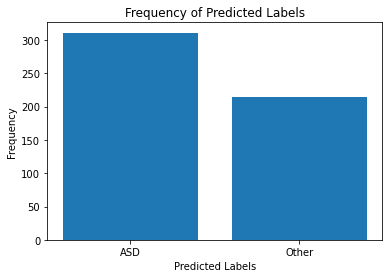

In [ ]:
# plot 
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Predicted Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Predicted Labels')
plt.show()

In [ ]:
# the model predictied 311 subreddit as being in the class ASD
# dorp the irelevant subreddits ( in the Other category )
asd_subs_df_final = asd_subs_df[asd_subs_df['predicted_label'] != 'Other']
asd_subs_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311 entries, 0 to 533
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               311 non-null    object
 1   display_name     311 non-null    object
 2   text             311 non-null    object
 3   lang             311 non-null    object
 4   predicted_label  311 non-null    object
dtypes: object(5)
memory usage: 14.6+ KB


In [ ]:
# save the final dataset
file_path = 'data/final_asd_subreddits_list.csv'
asd_subs_df_final.to_csv(file_path, index=False)

to do : add pseudo code ( if-then ) for the code/model used
to do : add a flow chart for the model architercutre ( how the data will be processed )

THE NEW APPROCH WILL INVOLVE GET ALL SUBMISSIONS FROM ALL SUBREDDITS : USING 2 KEY WORDS FROM THE WORBANKS , ONE RELATED TO AUTISM AND THE OTHER RELATED TO ABA

CODE IN : asd_aba_submissions_all_subreddits.ipynb